In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.ndimage
import seaborn as sns
from PIL import Image
import spatialinfo.spatial_information as si

# Pallial Spatial Representations

This notebook collates high-level analysis approaches after df/f extraction. For now, I assume the following data structure for datasets collected in a folder *processed_datasets*:
```
processed_datasets/
├── yyyymmdd_Area_AcqNr/
│   ├── yyyymmdd_Area_AcqNr_dff.pkl
│   ├── yyyymmdd_Area_AcqNr_behavior.pkl
│   ├── yyyymmdd_Area_AcqNr_anatomy.tif
│   ├── yyyymmdd_Area_AcqNr_masks.png
│   ├── yyyymmdd_Area_AcqNr_cm.tif
```

To do: 
- incorporate also the dataset for the full behavioral analysis, so that it is possible to extract from which trial and experimental stage any given imaging data is obtained from

Goals:
- Computational measure for place coding
- Distribution of place fields over corridors
- Dependence on experimental stage (social reinforcement vs spatial cues only)
- Visualize neurons with high spatial information in the anatomy
- Try and decode location from population activity

I will start by implementing spatial information measures described in [Yang, C. et al., *A population code for spatial representation in the zebrafish telencephalon*, **Nature 1-10 (2024)** doi:10.1038/s41586-024-07867-2](https://www.nature.com/articles/s41586-024-07867-2#Sec21): 

*A spatial activity map was generated for each neuron, representing the mean neural activity at each spatial location. To calculate the spatial activity map the chamber was divided into square bins (side length 1.2 mm) and then the summed neural activity and occupancy time were calculated for each bin. This resulted in two matrices: a summed neural activity matrix and an occupancy matrix (matrix entries correspond to spatial bins). We then applied a boundary-constrained Gaussian filter (standard deviation one bin, with the boundary defined by the chamber boundary) to these two matrices. The spatial activity map was calculated by dividing the filtered summed neural activity matrix by the filtered occupancy matrix to obtain the filtered average activity in each spatial bin. When the fish was stationary (speed below 0.1 mm/s), the corresponding frames were not included in the calculation of the spatial activity map. For all experimental spatial activity maps (for example, for comparison of spatial maps across sessions) we exclude the first 15 min following initial exposure to the environment in S1. For within-session control (comparison between the first and second halves of S1) we separately generated spatial activity maps for the first and second halves of S1. The first 15 min were not excluded in the within-session control, to ensure sufficient coverage of the environment by the fish trajectory.*

*From the spatial activity map of each cell, spatial information can be used to quantify how much information is contained by that cell about the location of the animal, in units of bits per seconds. For each cell, spatial information I was calculated as*

$I = \sum_{x} \lambda(x) log_{2} \frac{\lambda(x)}{\lambda}P(x)$, 

*where x is a spatial bin, P(x) is the probability that the fish is in the spatial bin x, $\lambda(x)$ is the mean activity of the cell when the fish is in spatial bin x and $\lambda$ is average neural activity, computed as $\lambda = \sum_{x}\lambda(x)P(x)$.*

*Based on the equation above, cells with high average neural activity tend to have higher spatial information. To normalize for this we calculate specificity s as*

$ s = \frac{I}{\lambda}$

  

Defining place fields. The place field (PF, or firing field) of each neuron is defined as the set of spatial bins with activity above 80% of peak activity (with peak defined as the 95th percentile) of the spatial activity map. A more in-depth and systematic analysis of unimodal and multimodal PFs is described in Extended Data Fig. 1i–k, in which the activity threshold was swept from 50 to 80%. The location of the PF is represented by its center of mass (COM) for cells with a single PF. For cells with multiple PFs (as distinct components in the map) we use the COM of the component(over 20 bins, to avoid spurious PFs due to noise), with the highest peak activity (defined as the 95th percentile of the component) as the location of its primary PF. Only PCs with a PF size of less than 30% of chamber size are included in maps of the distribution of PFs and in the analysis of PF shift. PFs are used only for analysis of PF shift and visualization of PF location across an environment. All other analyses of PC activity, such as PF correlation, PV correlation, change in specificity and positional decoding, use the spatial activity map directly.

Given a list of neurons with a sufficiently high spatial specificity to be counted as bona fide place cells, we want to highlight where they are found within the recorded area. For this, the index of place cells has to be passed to the neuron mask and superimposed on the anatomy of the recorded area. 
```
│   ├── yyyymmdd_Area_AcqNr_anatomy.tif
│   ├── yyyymmdd_Area_AcqNr_masks.png
│   ├── yyyymmdd_Area_AcqNr_cm.tif
```

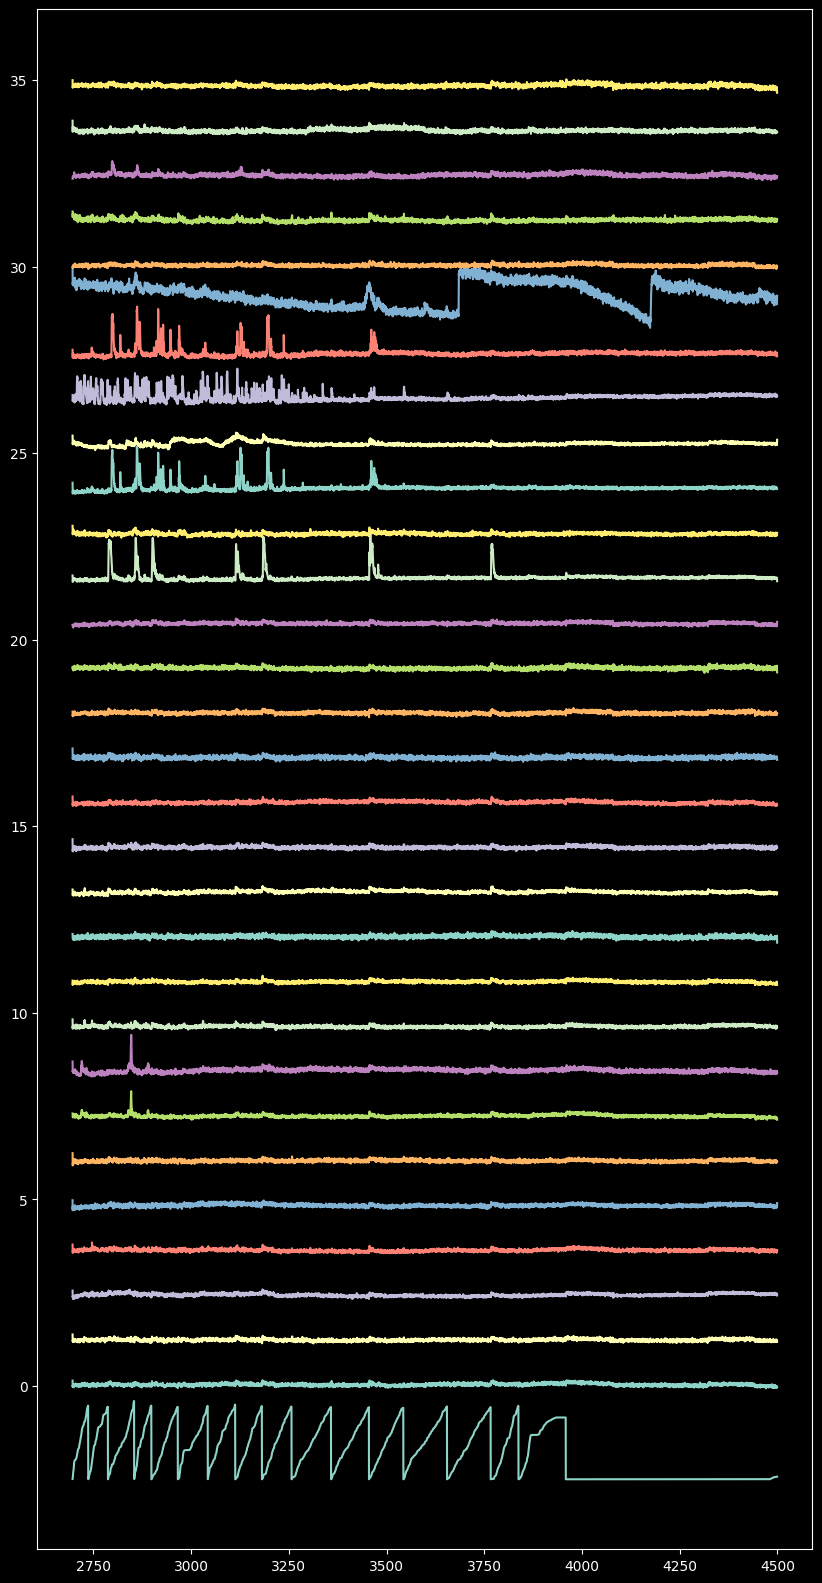

In [87]:
# for acquisitions after 2025/07, run this box:

dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20250722_Dc_2\\'))

bh.columns = ['timestamp', 'trial', 'trial index', 'X', 'Y', 'velocity',
       'tail tracking framecount']

# inspect data:
plt.figure(figsize=(10,20))
for i in range(30):
    plt.plot(bh["timestamp"],dff.iloc[:,i]+i*1.2)
plt.plot(bh["timestamp"],bh["Y"]-2.5)


In [ ]:
# subset the dataset if visual inspection indicates so
#dff = dff[0:38000]
#bh = bh[0:38000]

In [88]:
time_per_bin, summed_traces, _ = si.binning(dff, bh)
avg_act_mtx = si.avg_activity(time_per_bin, summed_traces)
spatial_info, spatial_spec = si.spatial_info_calc(avg_act_mtx, time_per_bin)

spec_z_score_values = si.spec_z_score(dff, bh, n_permut=100, n_bins=30)
pop_z_score_values = si.pop_z_score(spatial_spec)

df = pd.DataFrame({"spatial_specificity": spatial_spec, 
 "specificity_zscore": spec_z_score_values,
 "population_zscore": pop_z_score_values})

indices = df[(df["specificity_zscore"] > 1) & (df["population_zscore"] > 1)].index.to_numpy()
indices

array([18, 20, 23, 37, 45, 47, 59, 86, 117, 118, 119, 120, 141, 144, 157,
       187, 188], dtype=object)

In [223]:
# execute this cell for older datasets (preceding 2025/07)
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20241203_Dc\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
time_per_bin, summed_traces, _ = si.binning(dff, bh)
avg_act_mtx = si.avg_activity(time_per_bin, summed_traces)
spatial_info, spatial_spec = si.spatial_info_calc(avg_act_mtx, time_per_bin)

spec_z_score_values = si.spec_z_score(dff, bh, n_permut=100, n_bins=30)
pop_z_score_values = si.pop_z_score(spatial_spec)

df = pd.DataFrame({"spatial_specificity": spatial_spec, 
 "specificity_zscore": spec_z_score_values,
 "population_zscore": pop_z_score_values})

indices = df[(df["specificity_zscore"] > 1) & (df["population_zscore"] > 1)].index.to_numpy()
indices

array([68, 71, 74, 82, 90, 92, 103, 117, 118, 121, 183, 220, 224, 232,
       233, 236, 237, 238, 247, 264, 265, 266, 267, 268, 284],
      dtype=object)

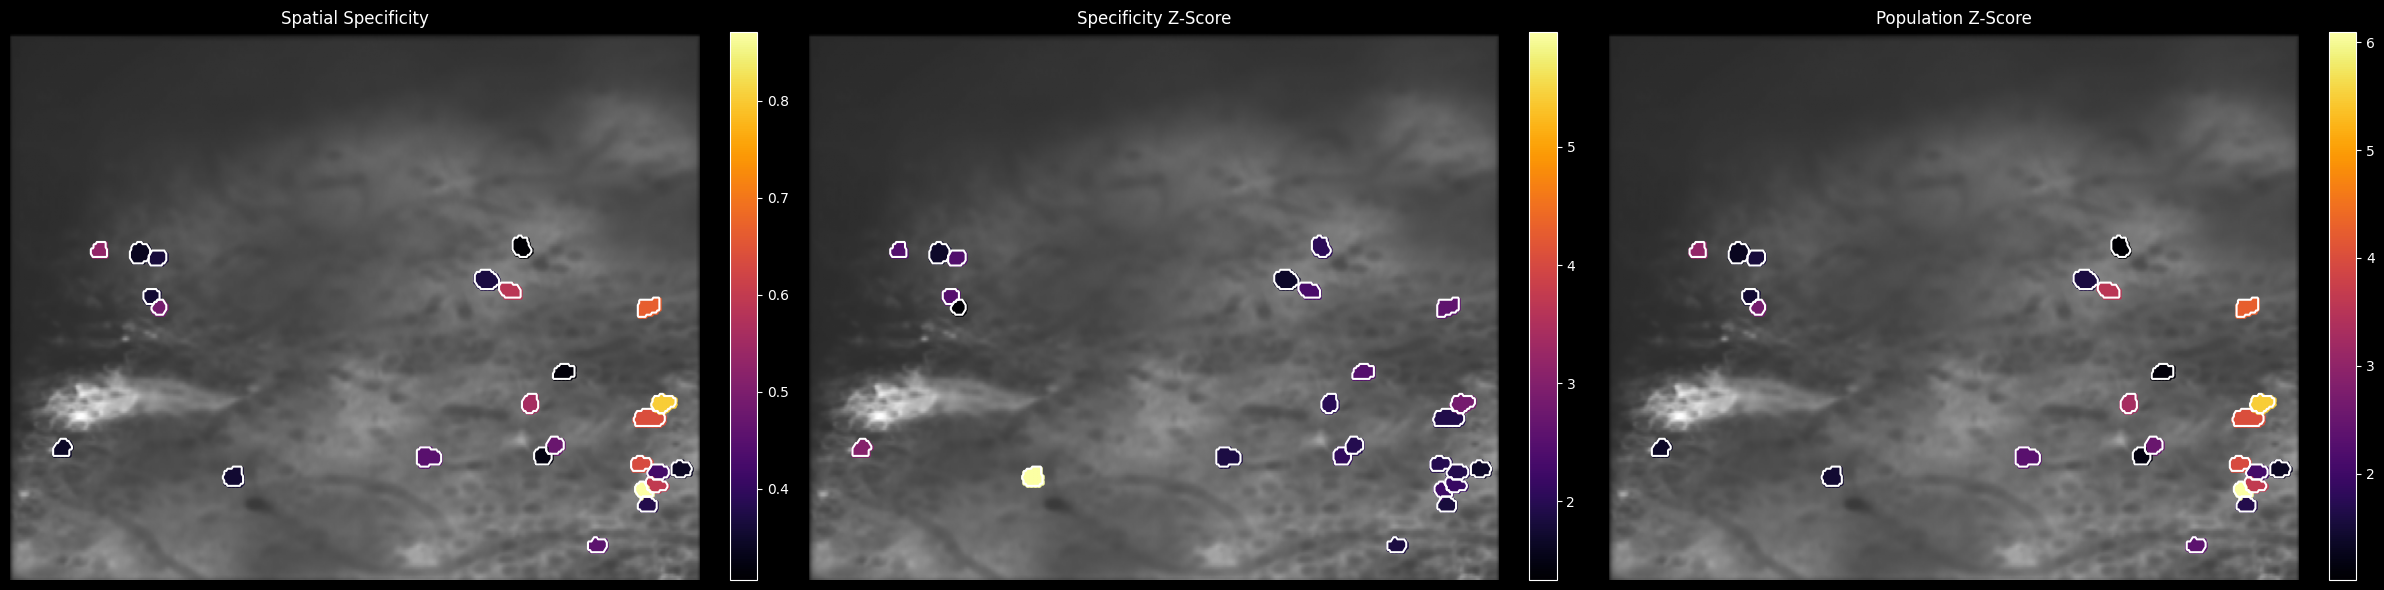

In [227]:
#indices = df[(df["specificity_zscore"] > 2)& (df["population_zscore"] > 0.5)].index.to_numpy()
#indices

si.plot_neurons(Path('..\\data\\processed_datasets\\20241203_Dc\\'),
             indices, df)

#si.plot_neurons(Path('W:\\scratch\\gfriedri\\anneluka\\Experiments\\VirtualReality\\data\\processed_datasets\\20240903_Dc_1\\'),
#            [179], df, save_figure=False)

#si.plot_neurons(Path('..\\data\\processed_datasets\\20250828_1300_DcLeft\\'),
#           [9, 43], df) 

#si.plot_neurons(Path('..\\data\\processed_datasets\\20250722_Dc_2\\'),
#            [37], df)

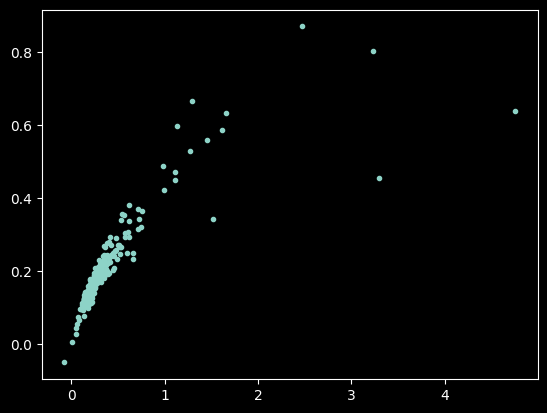

In [224]:
plt.plot(spatial_info, spatial_spec, '.')

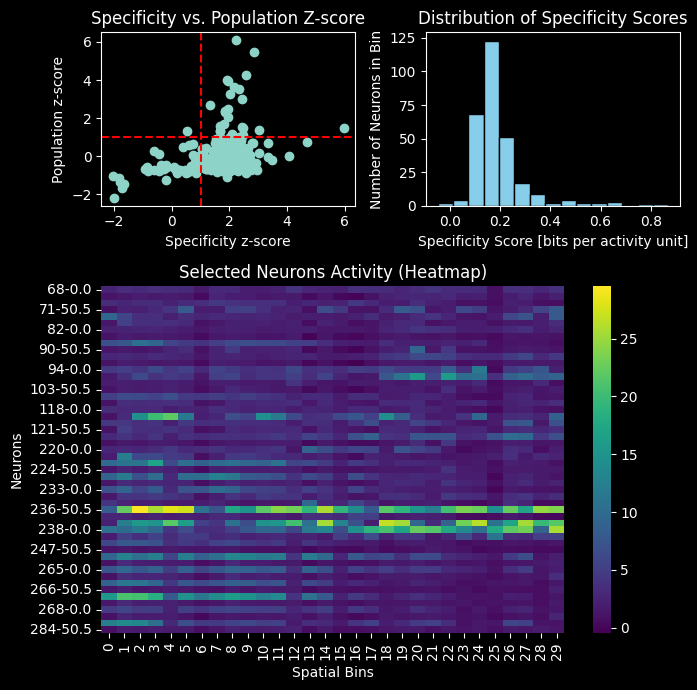

In [225]:
plt.style.use('dark_background')
# Create figure and GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])  # Two rows, two columns

# Subplot 1 (top left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(spec_z_score_values, pop_z_score_values, 'o')
ax1.axhline(y=1, color='r', linestyle='--')
ax1.axvline(x=1, color='r', linestyle='--')
ax1.set_xlabel("Specificity z-score")
ax1.set_ylabel("Population z-score")
ax1.set_title("Specificity vs. Population Z-score")

# Subplot 2 (top right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(spatial_spec, bins=15, color='skyblue', edgecolor='black')
ax2.set_xlabel("Specificity Score [bits per activity unit]")
ax2.set_ylabel("Number of Neurons in Bin")
ax2.set_title("Distribution of Specificity Scores")

# Subplot 3 (bottom, spanning two columns)
ax3 = fig.add_subplot(gs[1, :])
sns.heatmap(avg_act_mtx[pop_z_score_values.loc[pop_z_score_values>1].index].T, cmap="viridis", ax=ax3, cbar=True)
ax3.set_title("Selected Neurons Activity (Heatmap)")
ax3.set_xlabel("Spatial Bins")
ax3.set_ylabel("Neurons")

# Adjust layout
plt.tight_layout()
#plt.savefig("spatial_specificity.svg")
plt.show()

- ID652, Dc_1: 2, 3, 4, 5, 12, 15, 17, 21, 43, 44

- ID652, Dc_2: 0, 8, 11, 23, 47, 49, 51, 52, 65, 66, 75, 76

- ID20240903 Dc_1: 6, 8, 13, 18, 20, 45, 59, 81, (99), 106, 112, 136 (anti-motion), 179, 210, 211, 232, (254), 275, 278, 285 (both), 292, 301, 311, 318, 320 (both),   

- ID20240916 Dc_1: 2, 3, 4, 5, 6, 12, 15, 42, 43, 44, 59

- ID20240916 Dc_2: 8, 47, 49, 65, 66

- ID20240930 alDl_1: NA

- ID20241011 alDl_1: NA

- ID20241011 Dl_1: 16, 17, 55, 66, 74, 128, 135 [0, 2, 14, 15, 18]

- ID20241203 Dc: 68, 71, 74, 82, 90, 92, 103, 117, 118, 121, 183, 220, 224, 232,
       233, 236, 237, 238, 247, 264, 265, 266, 267, 268, 284
       

- 20250722 Dc: 37

- 20250722 alDl: 74, 128, 135
- 20250828 1300 DcRight: 7, 23, 24, 33, 36, 57, 64, 73, 95, 106

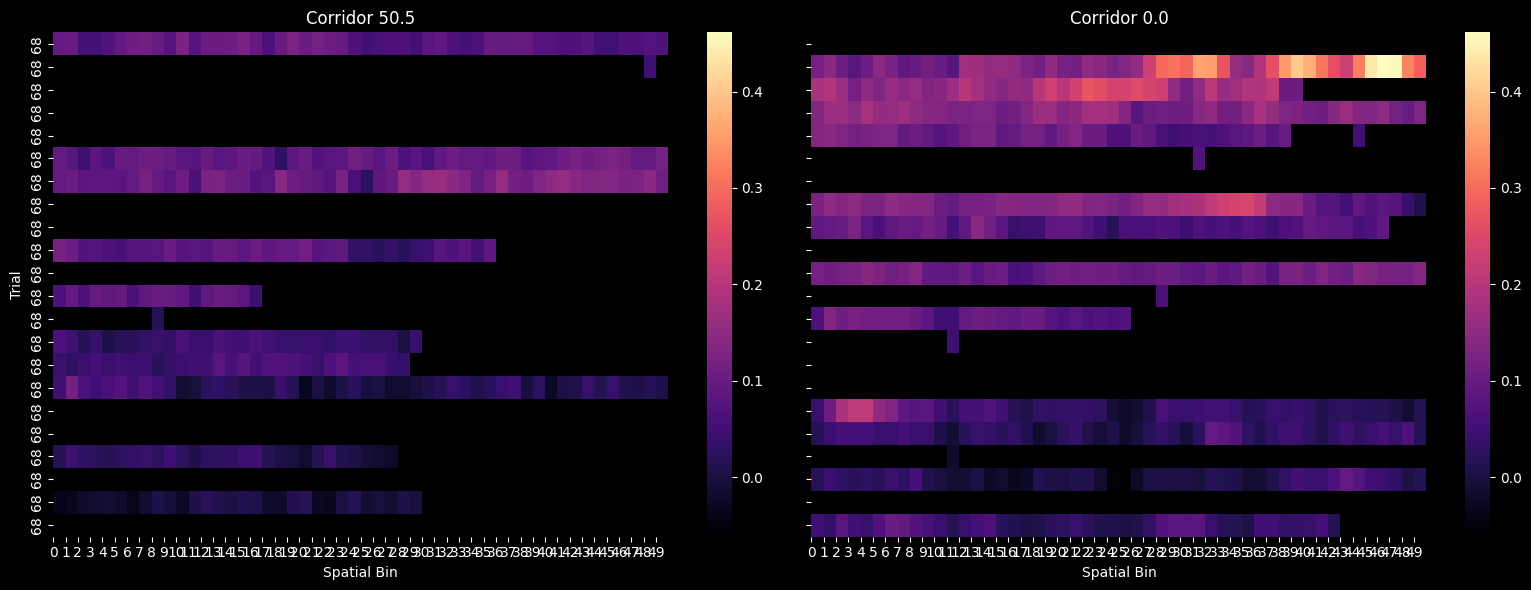

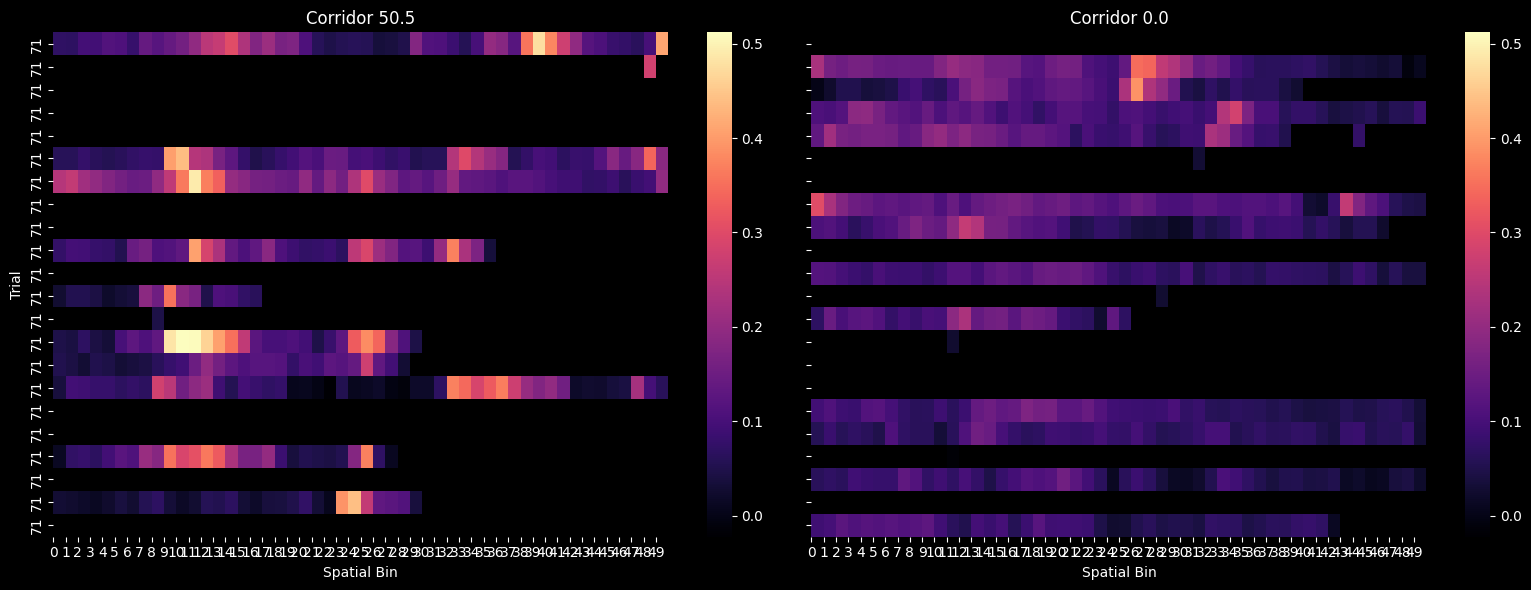

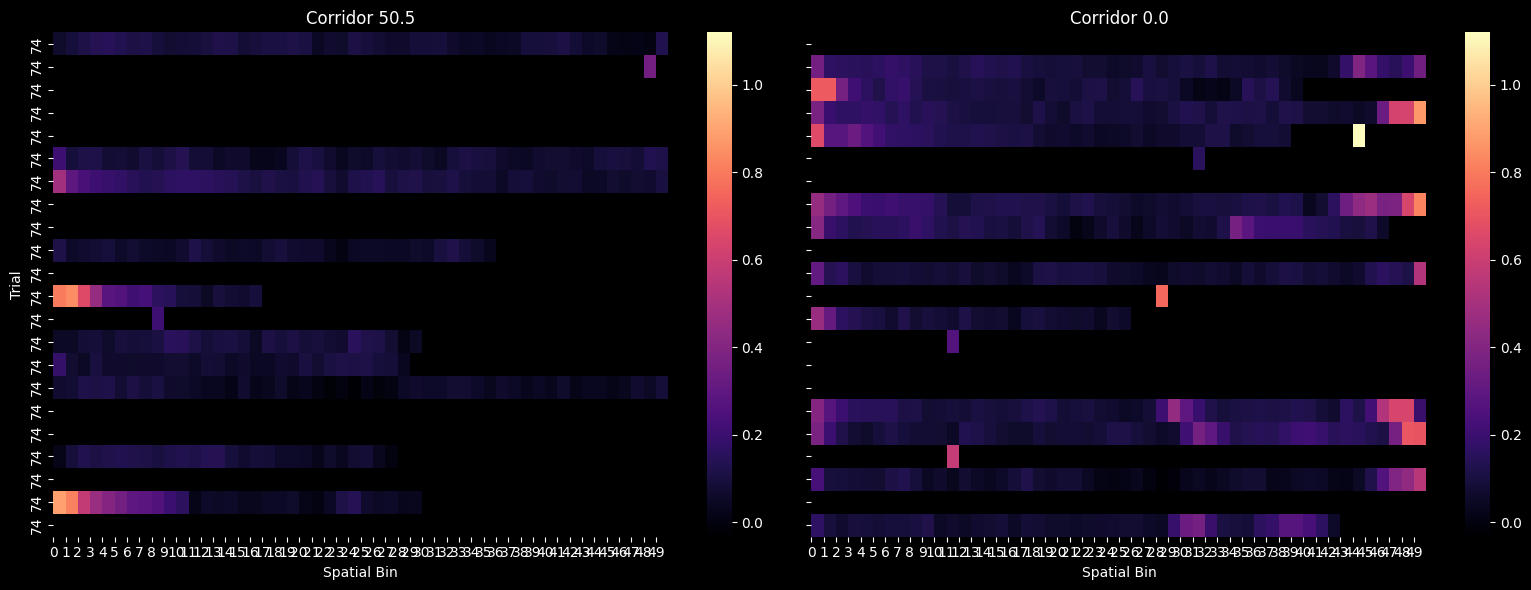

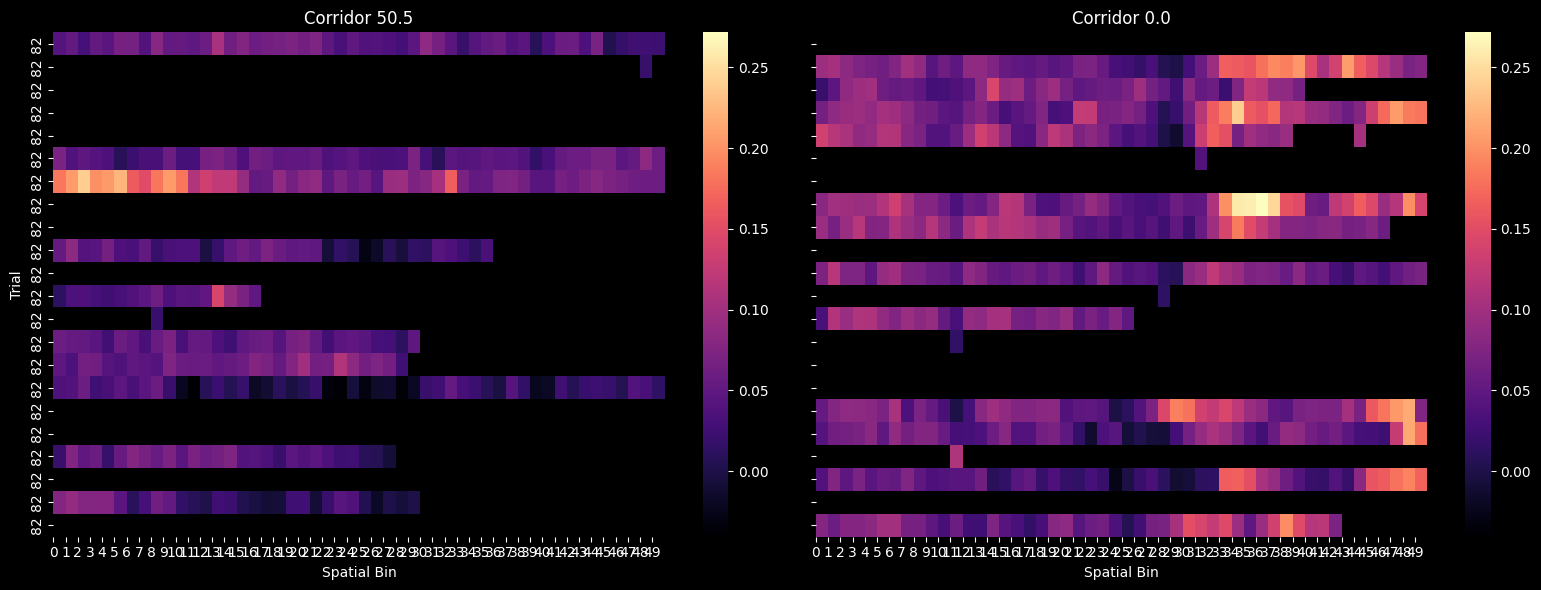

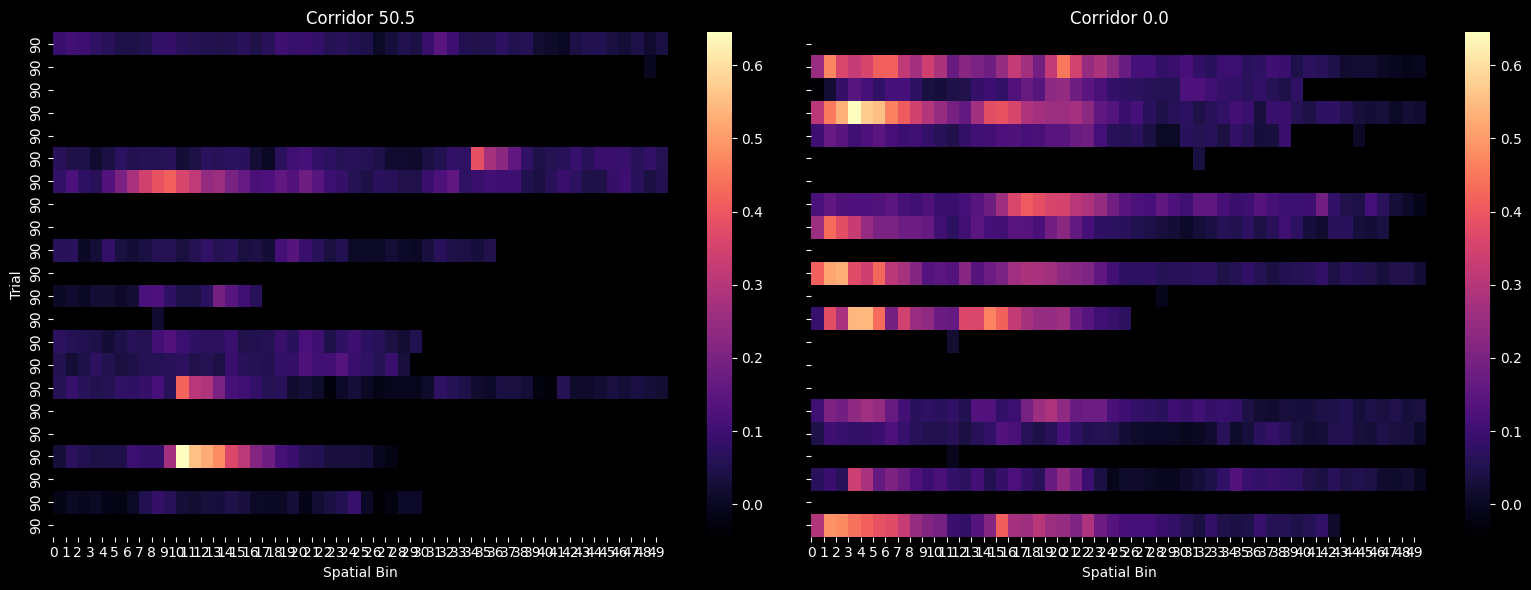

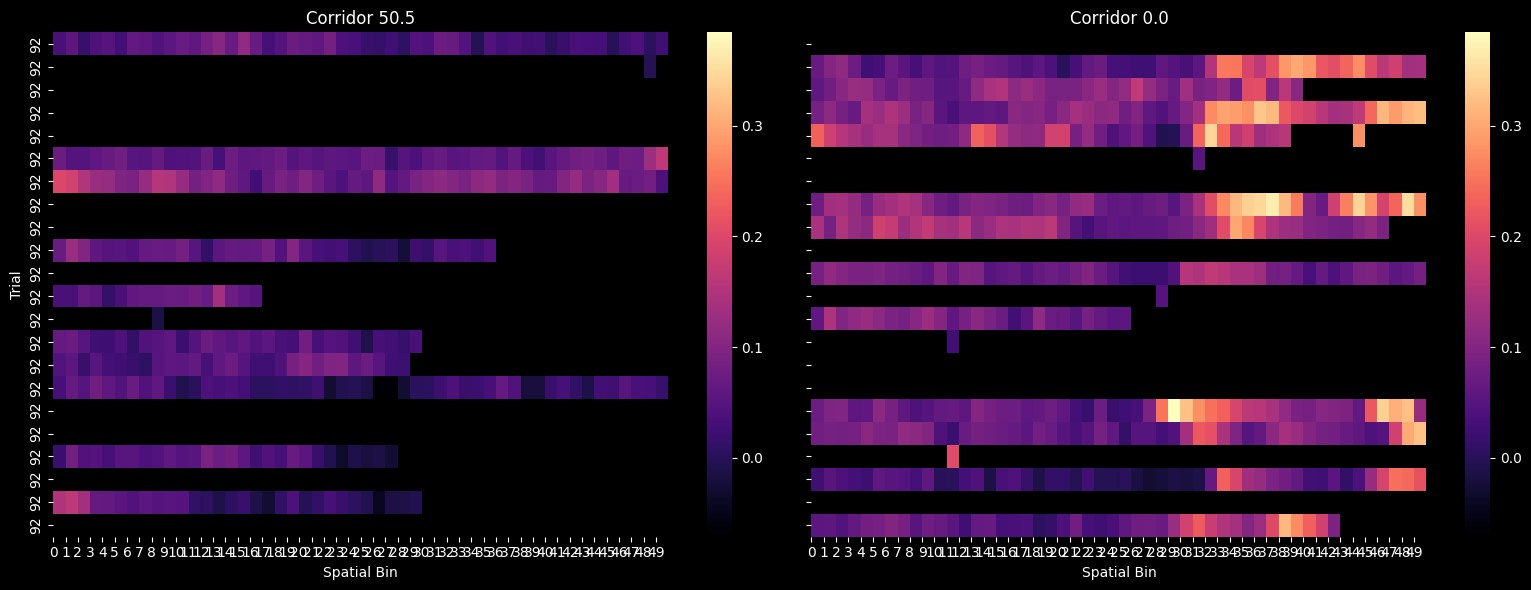

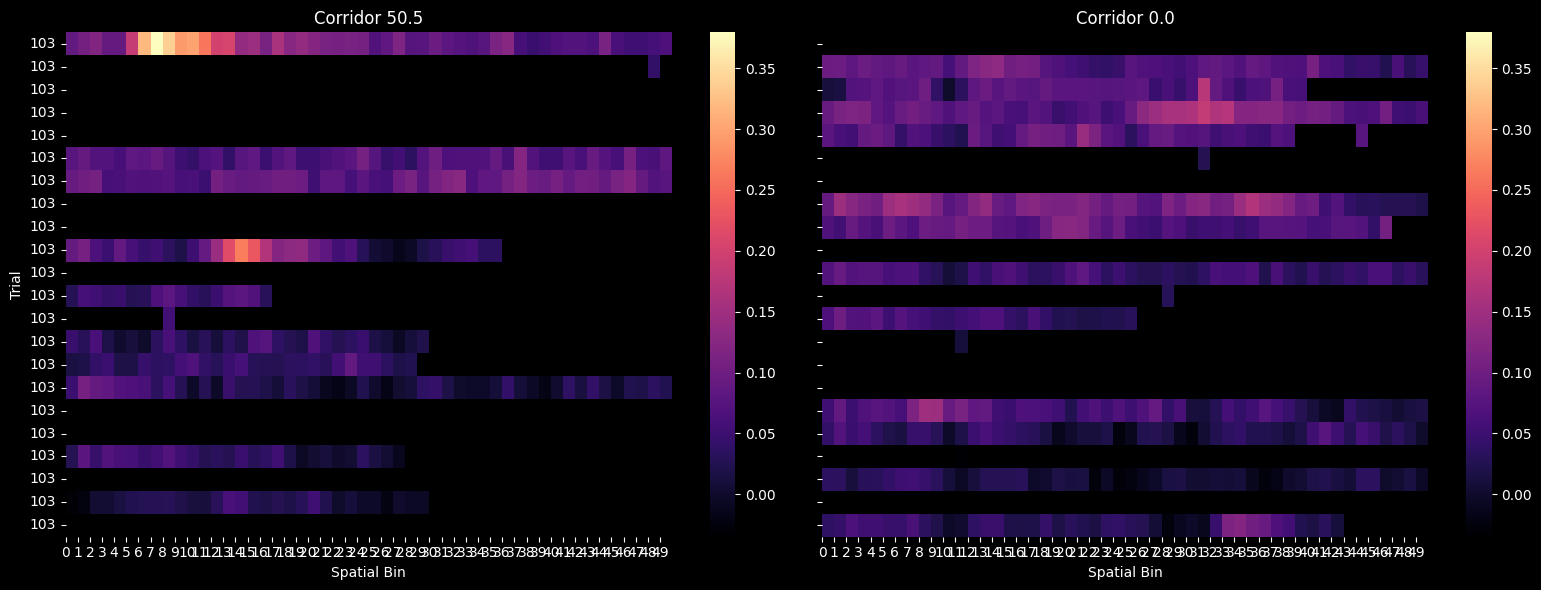

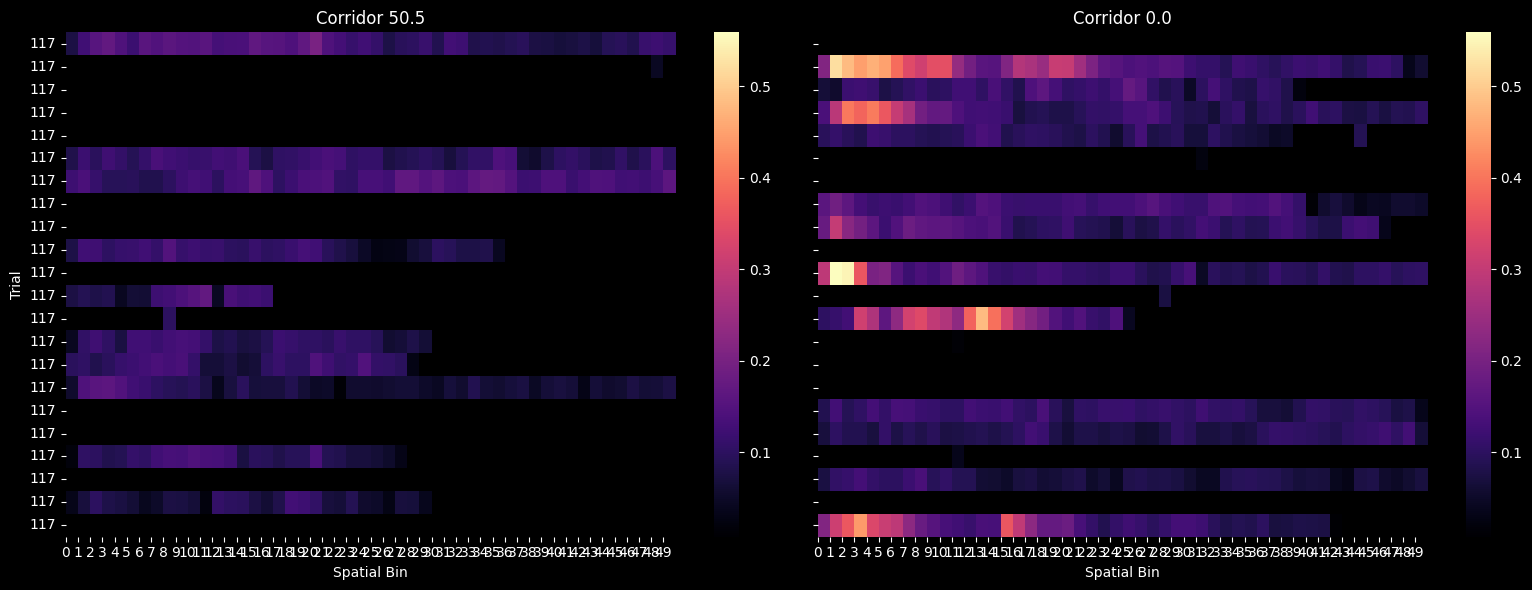

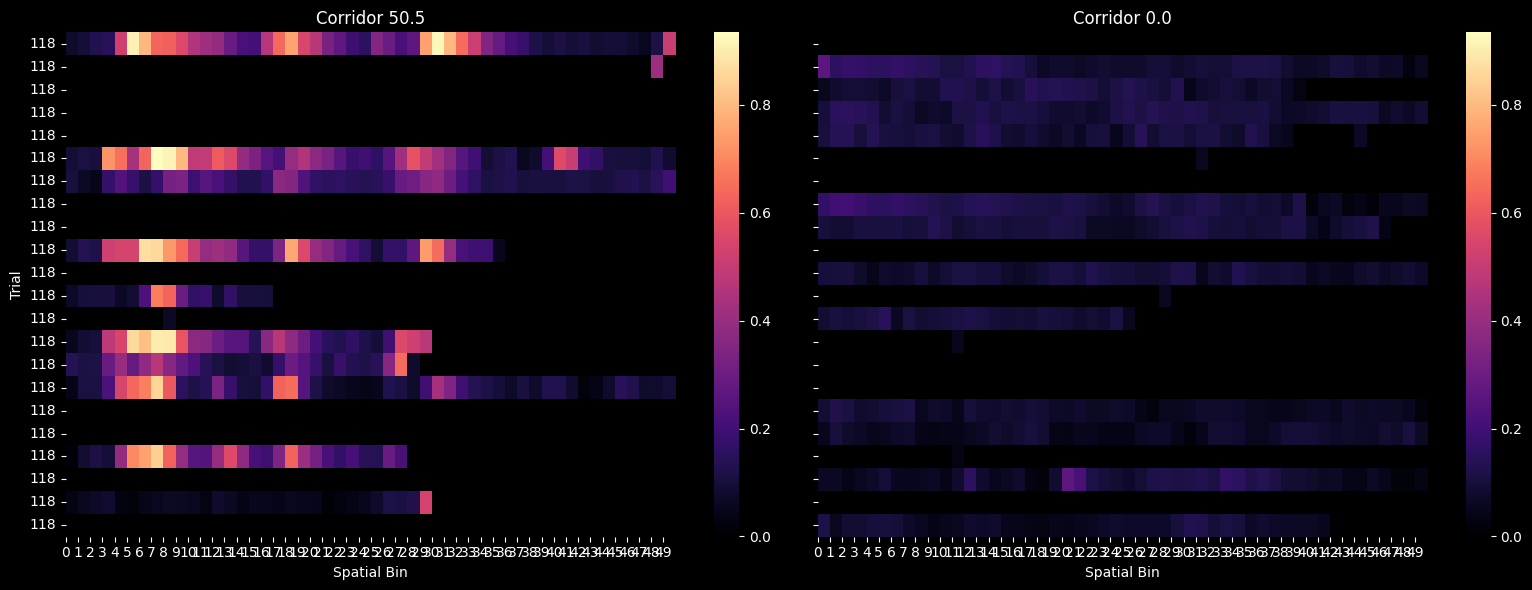

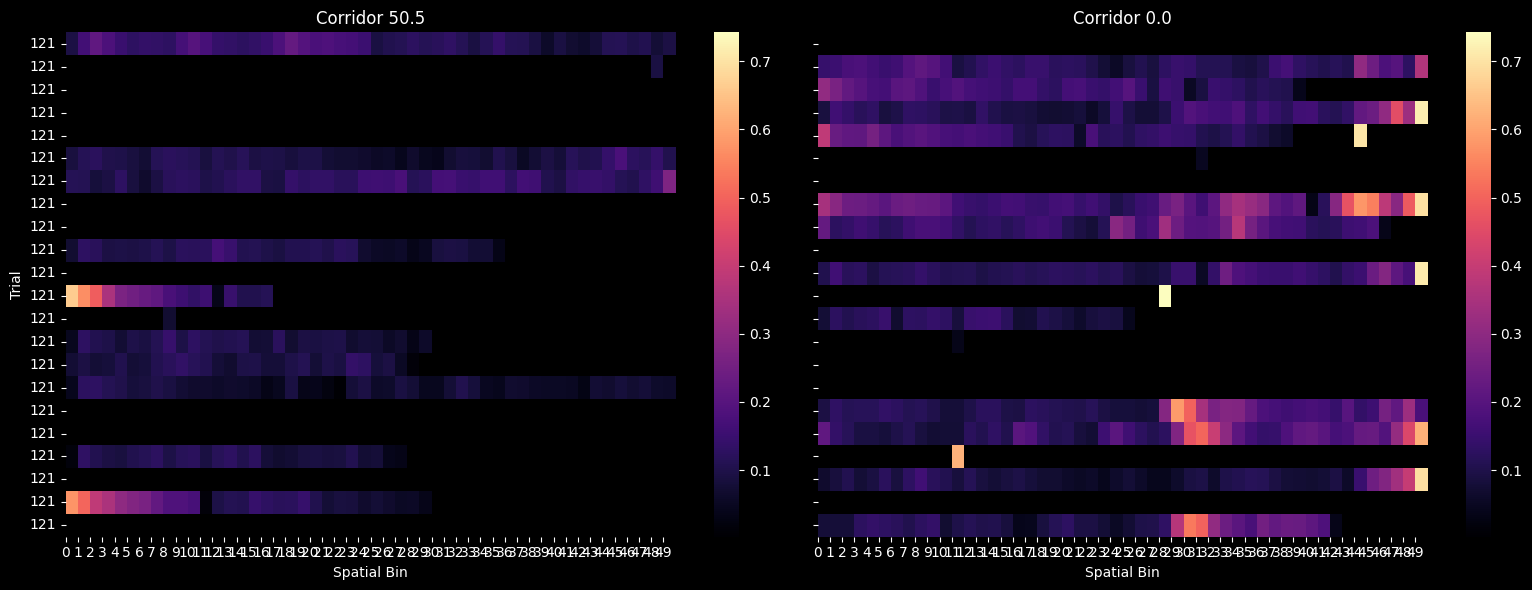

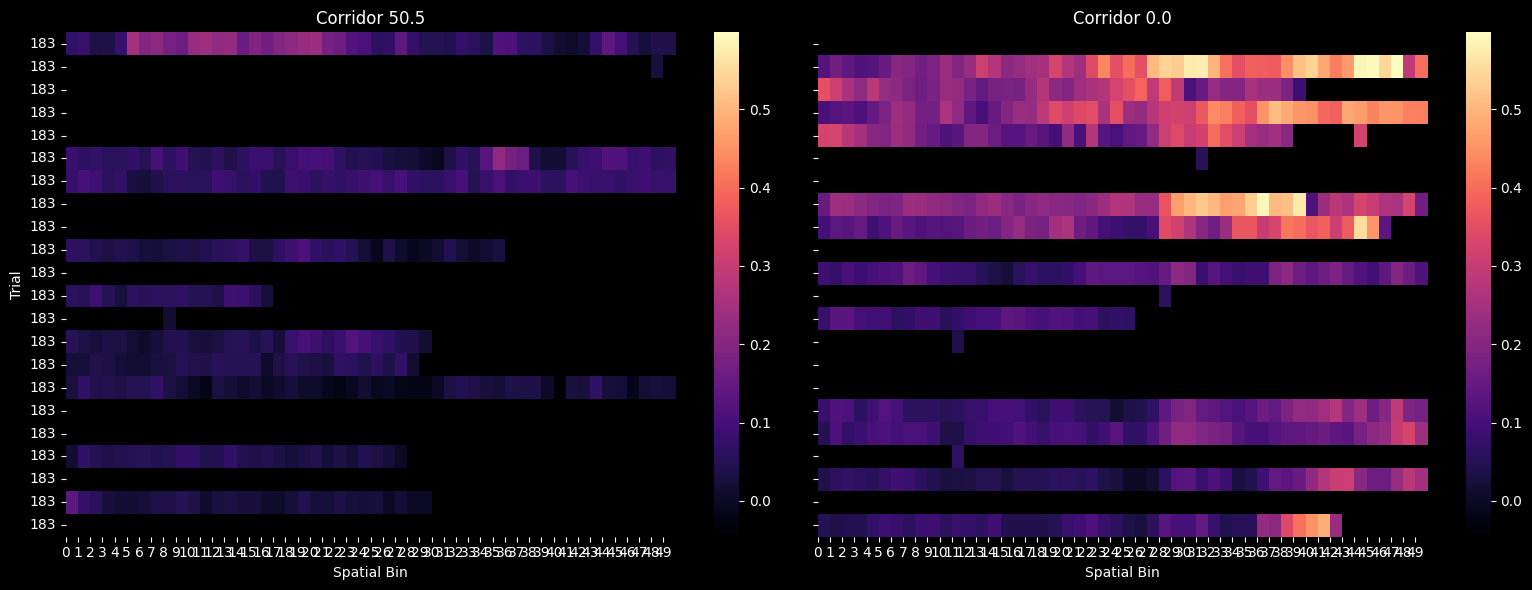

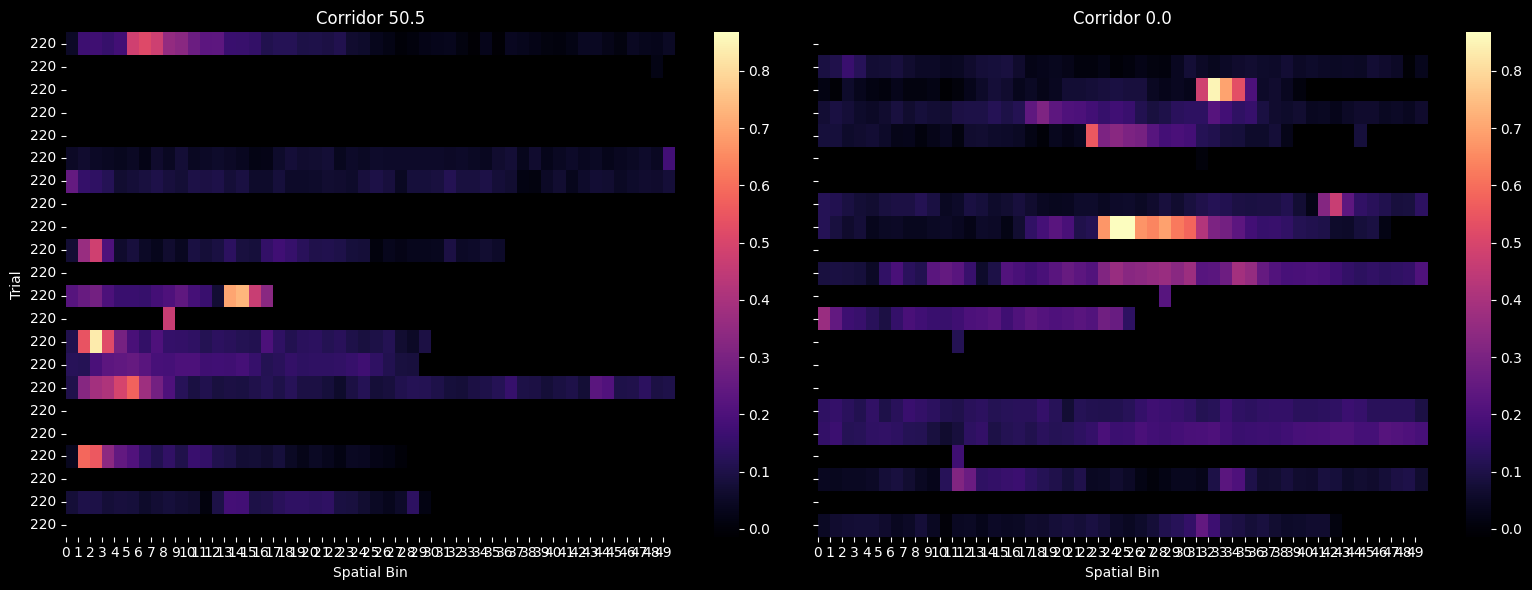

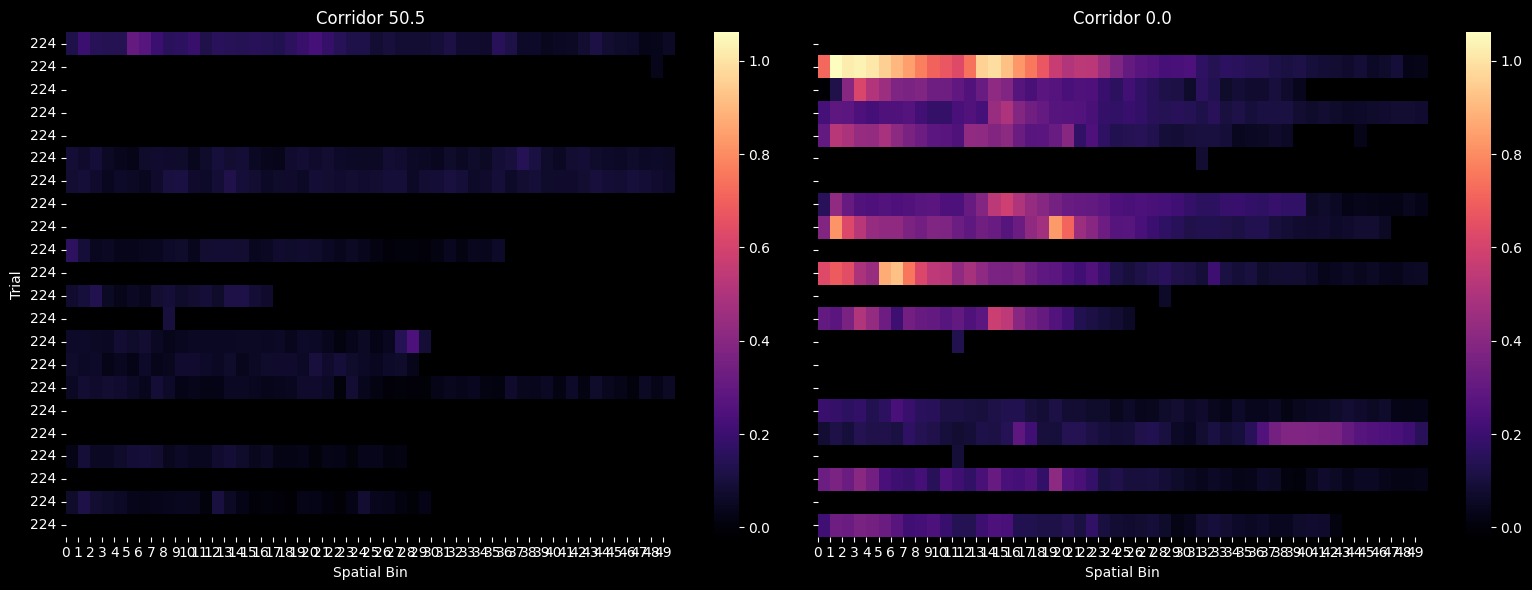

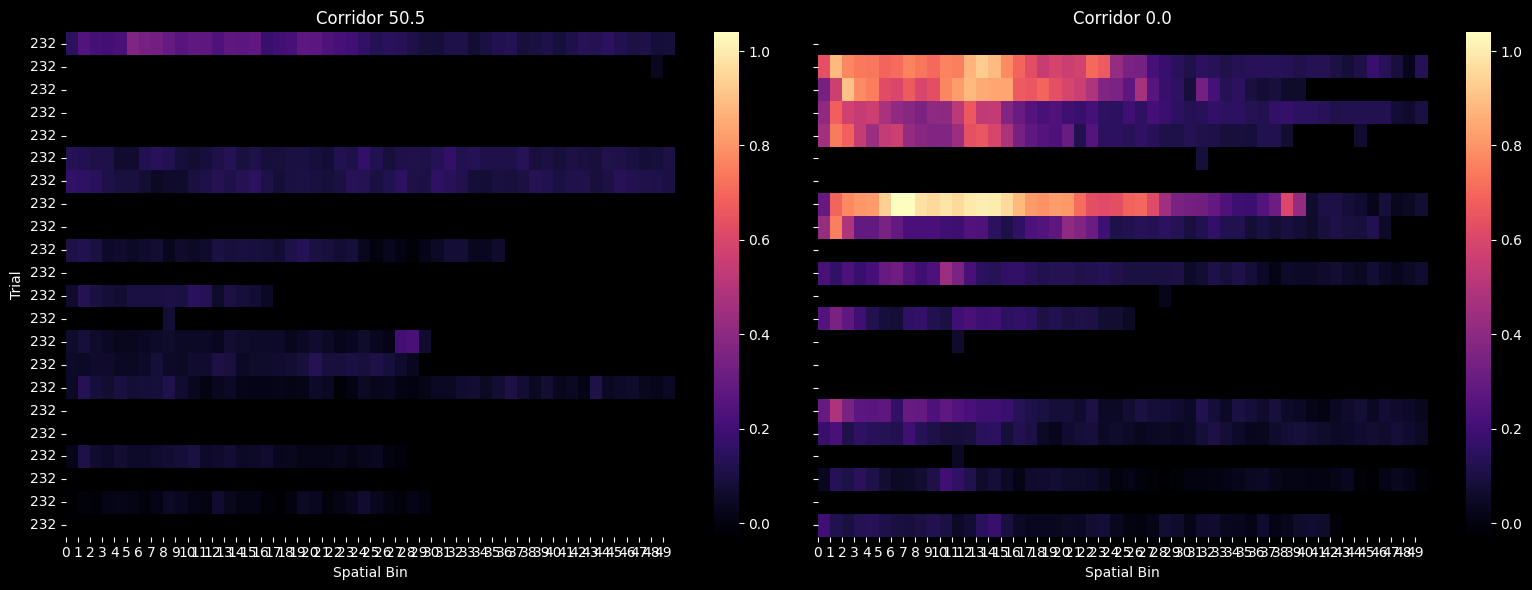

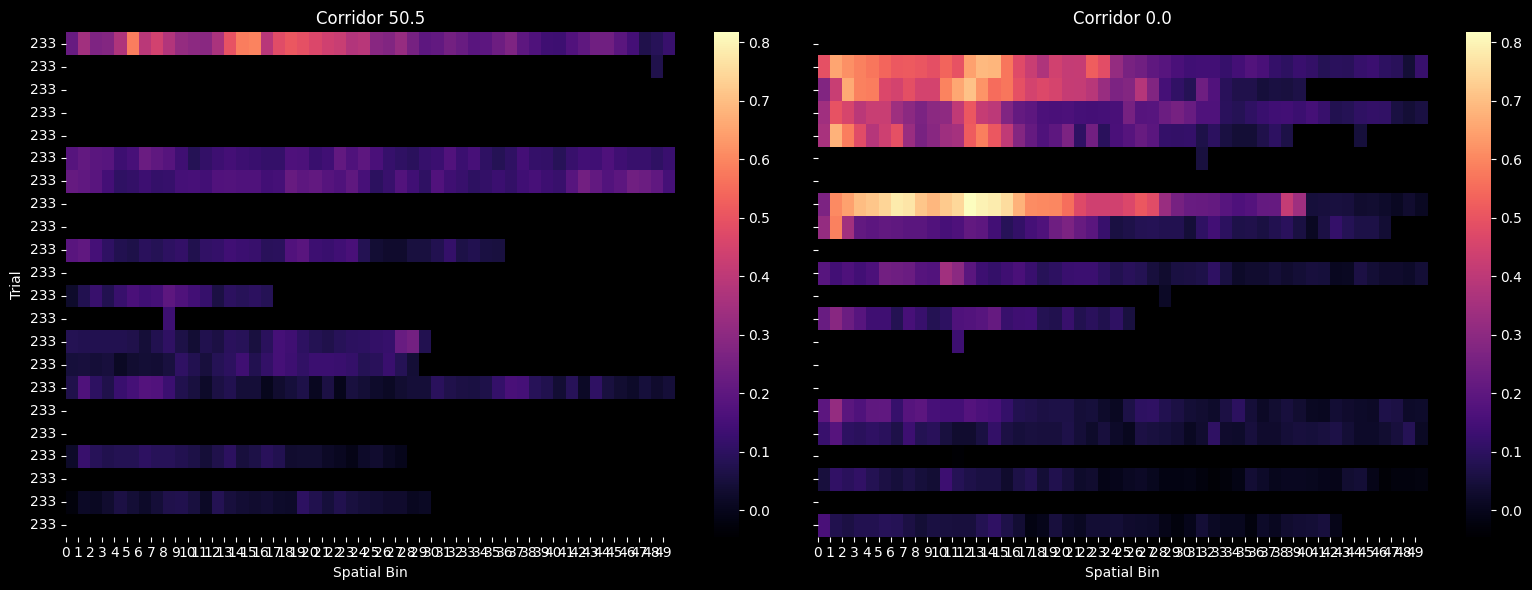

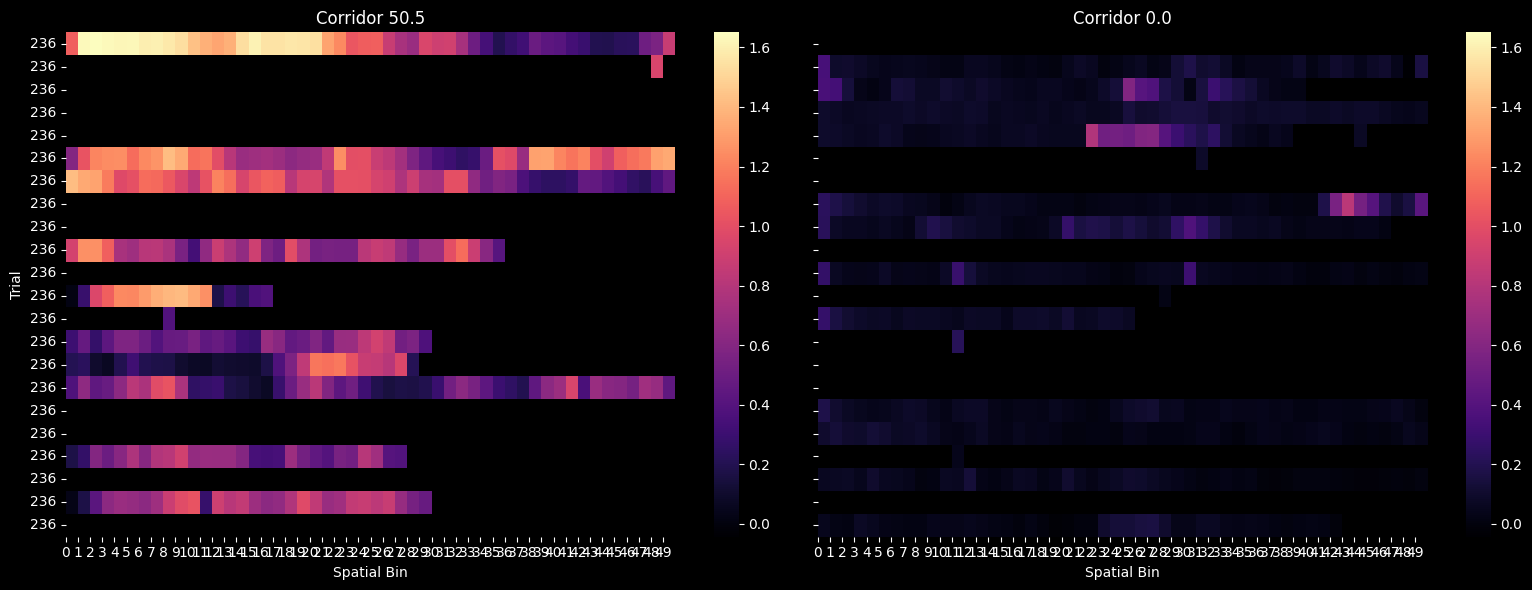

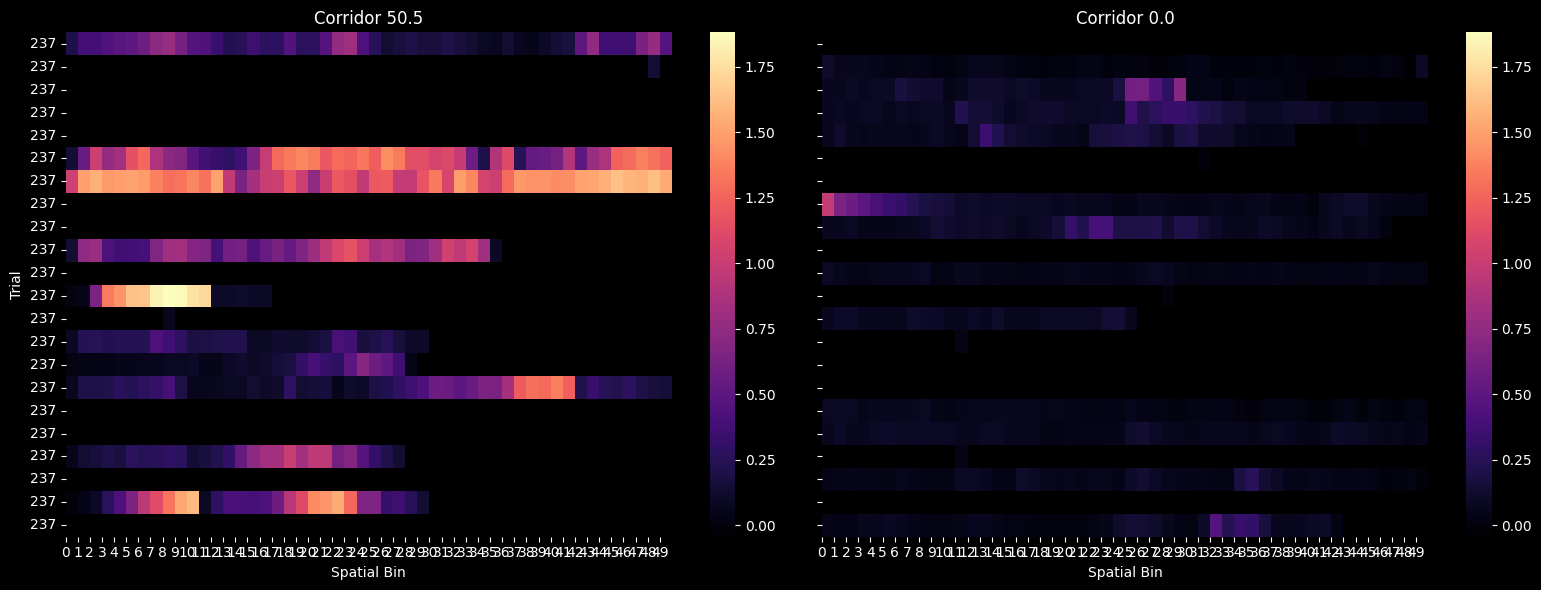

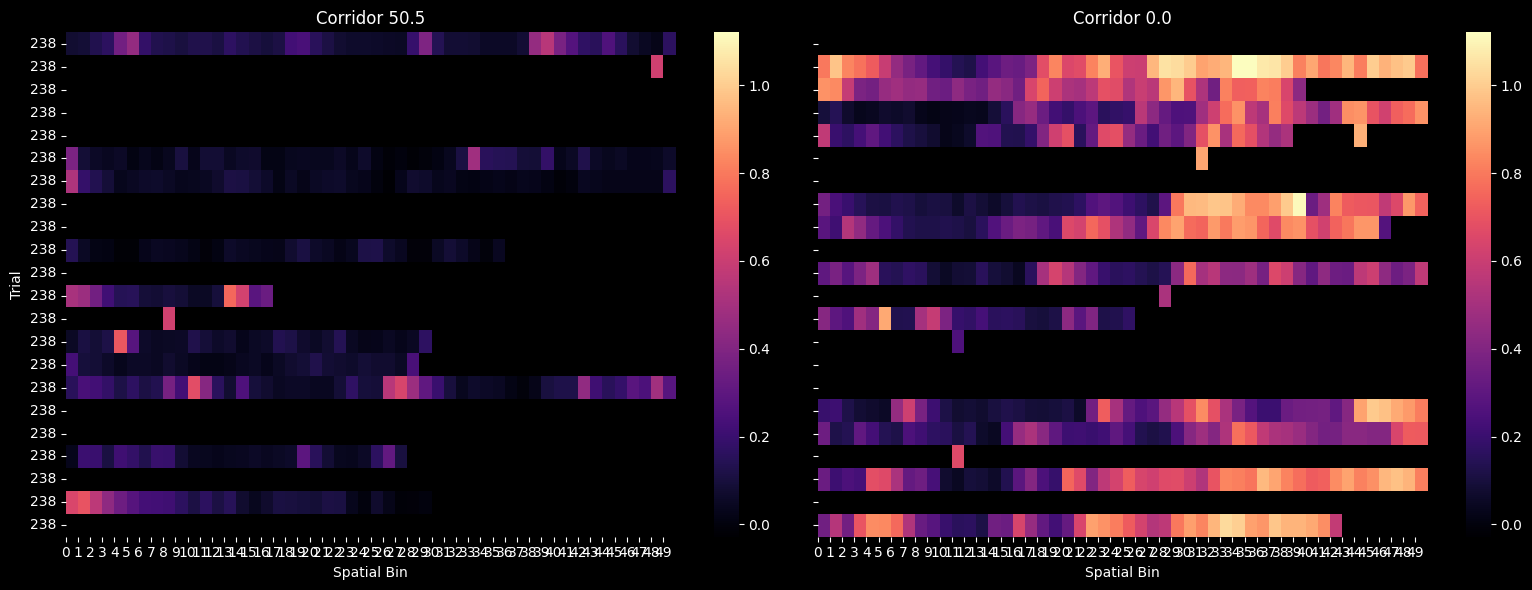

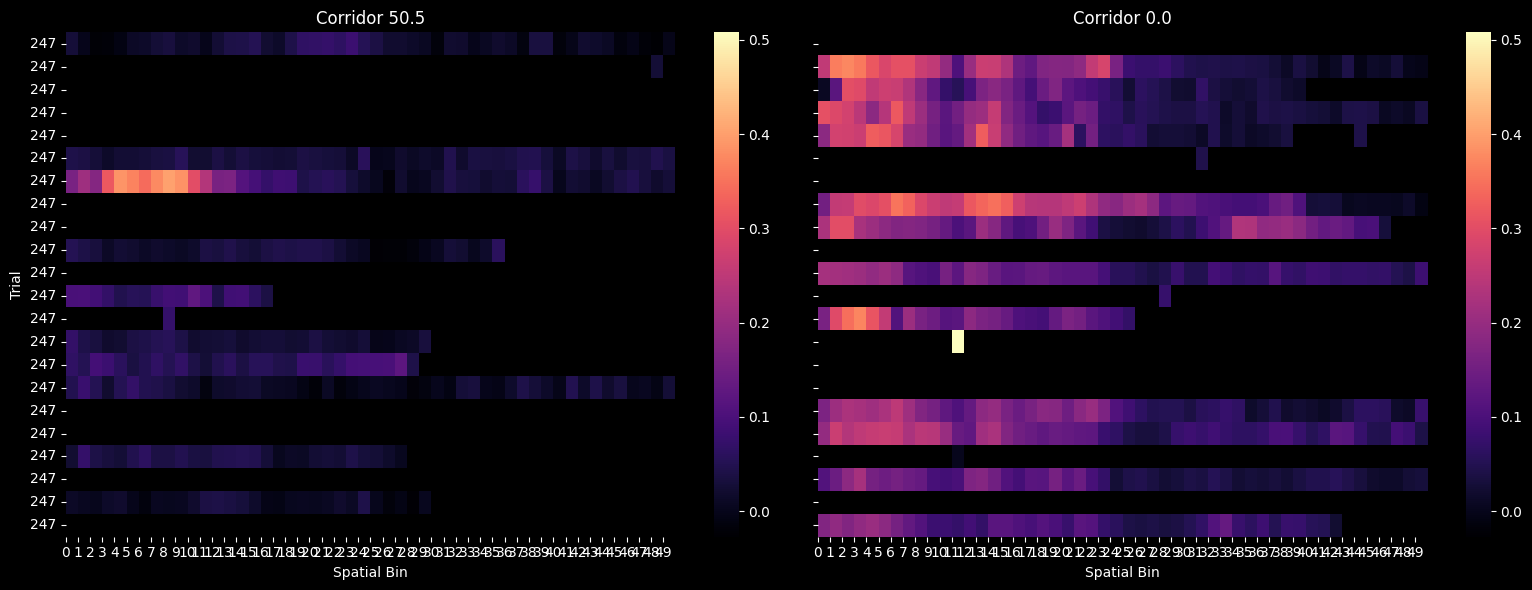

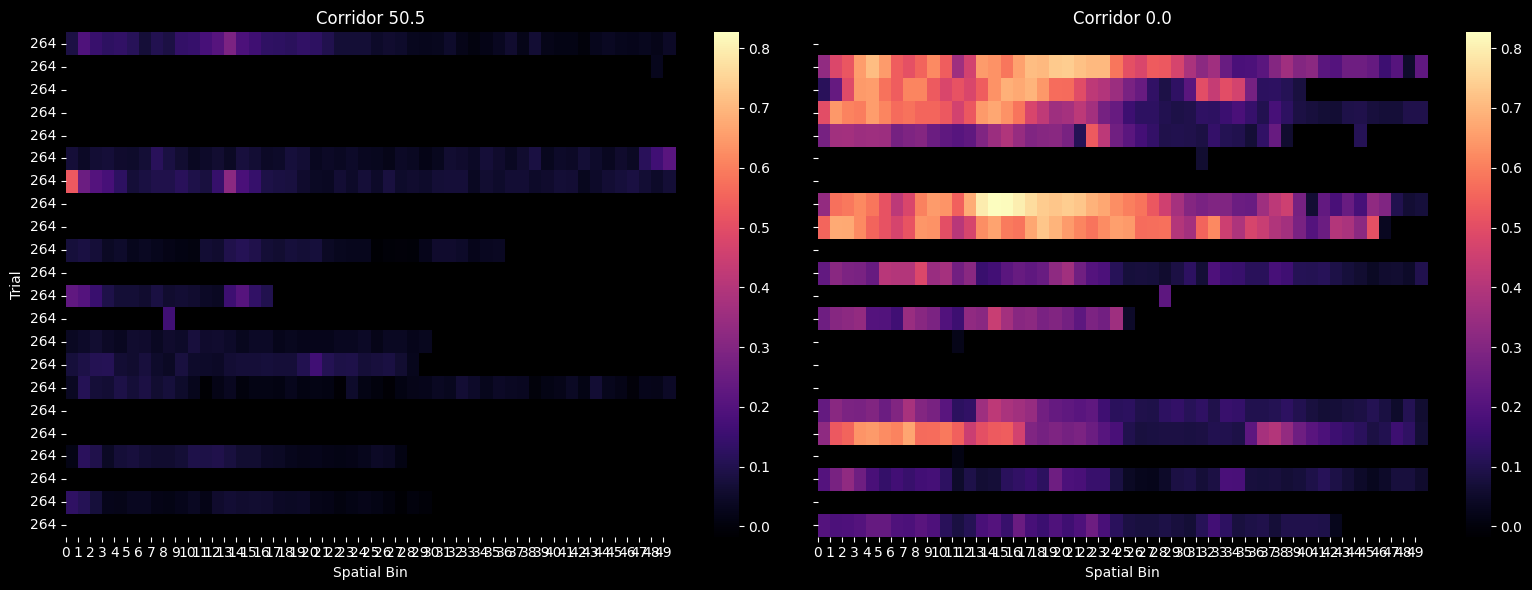

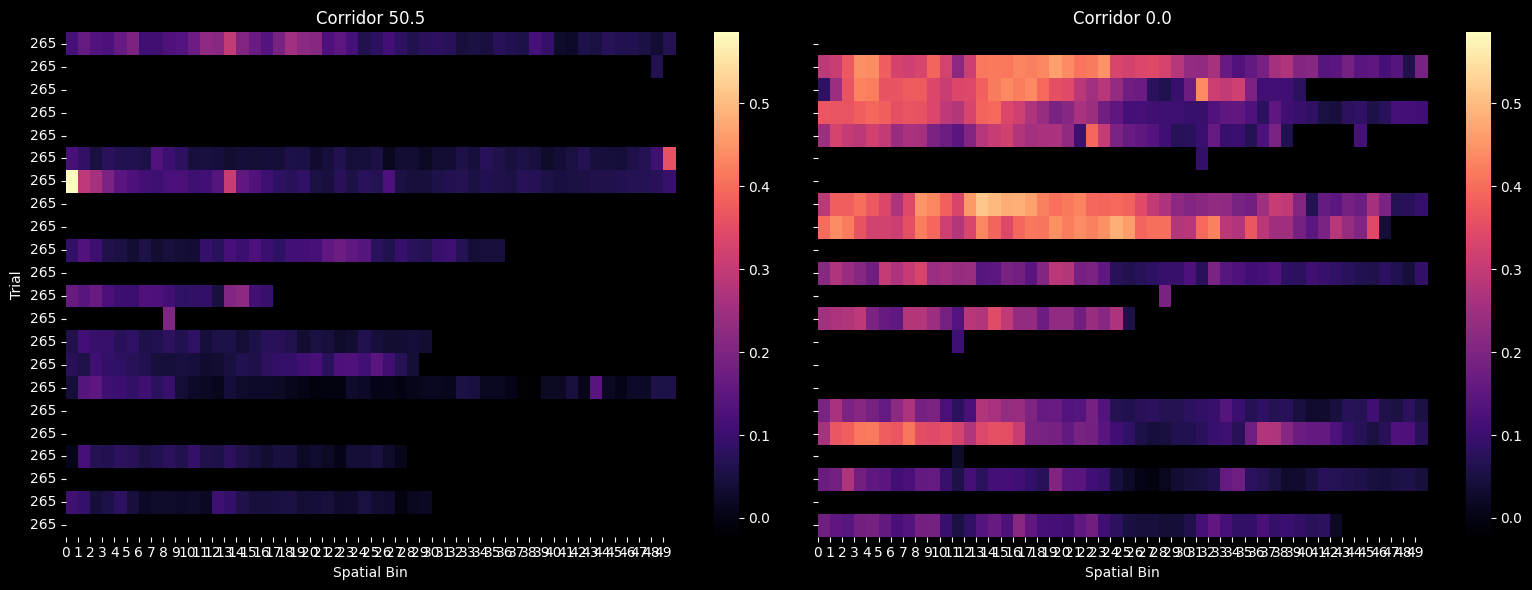

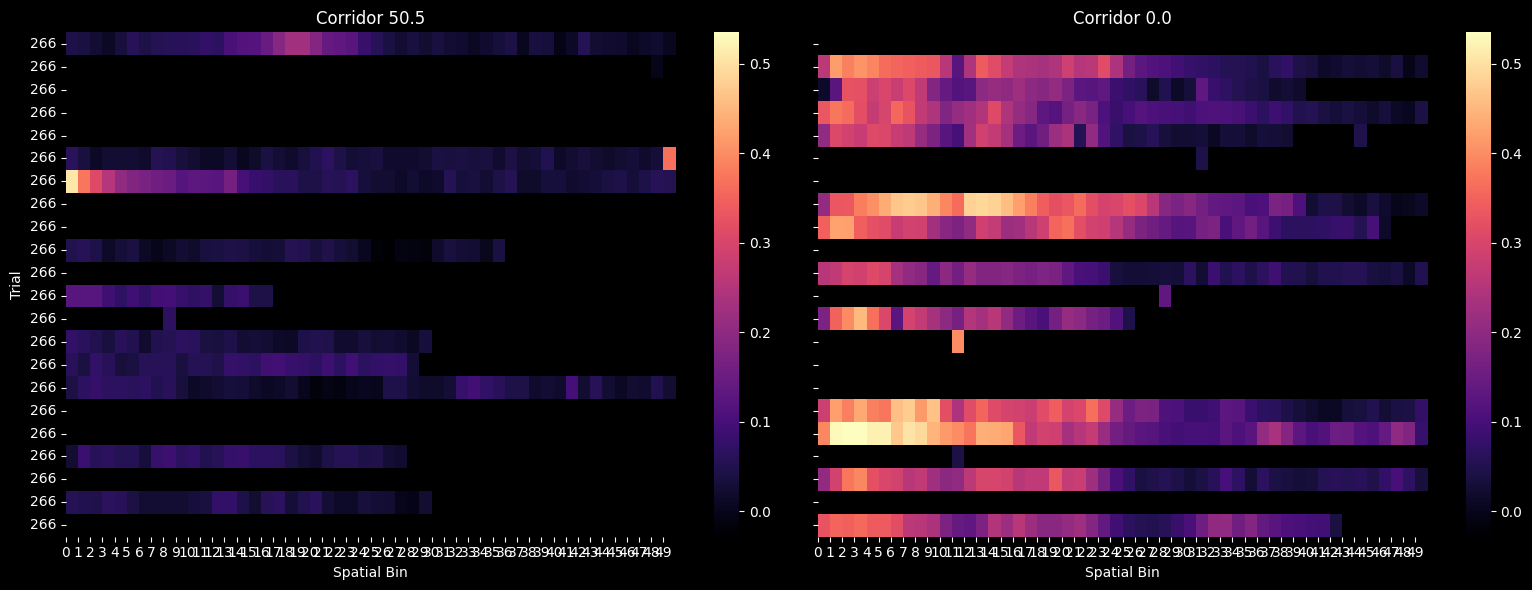

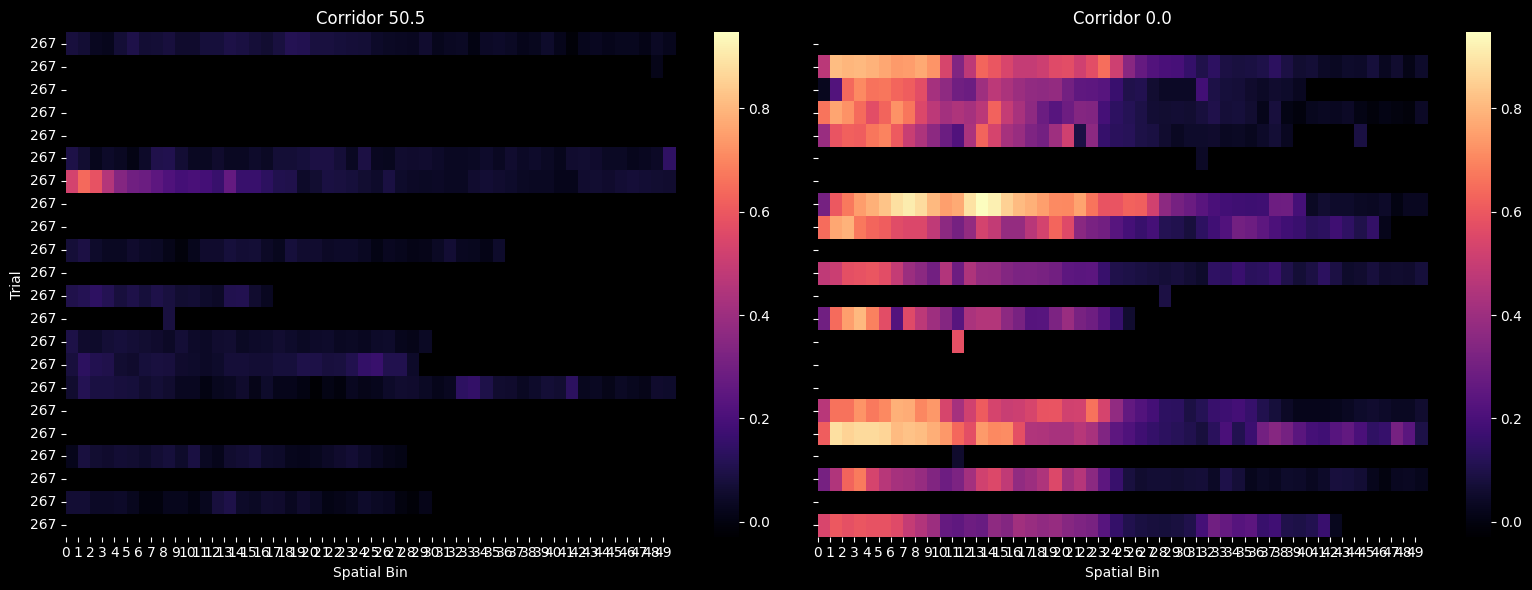

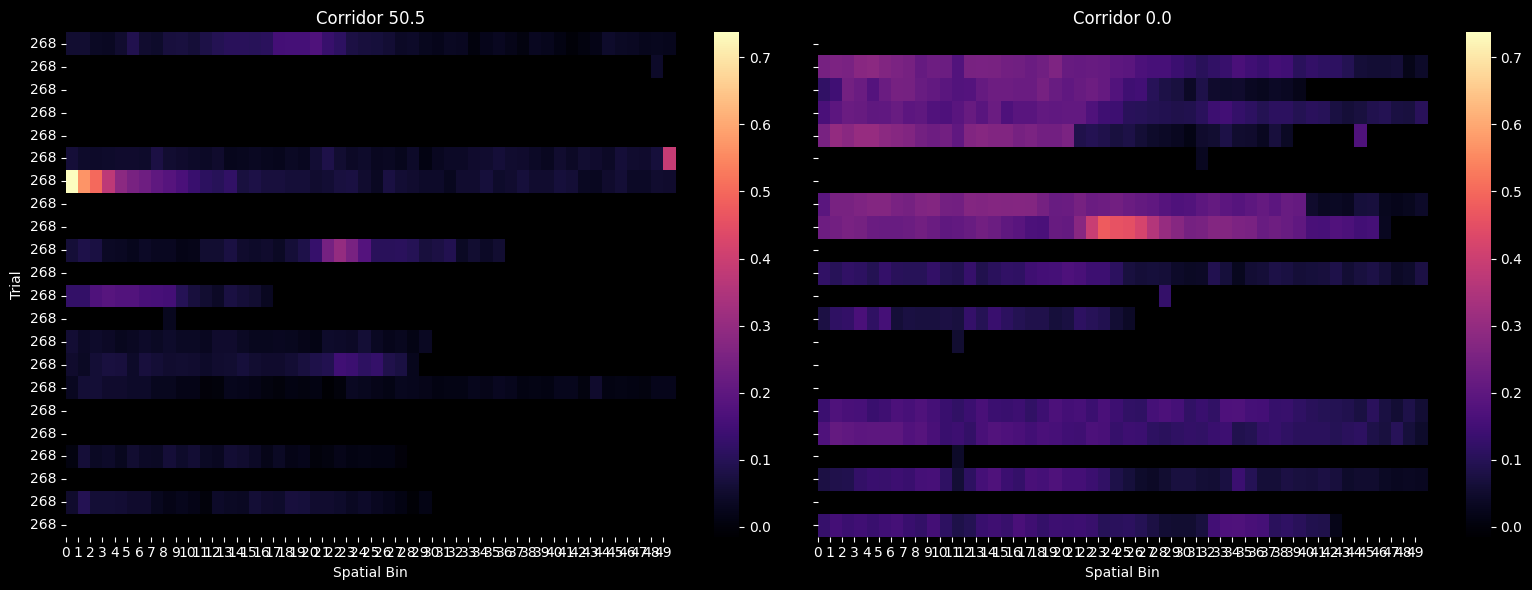

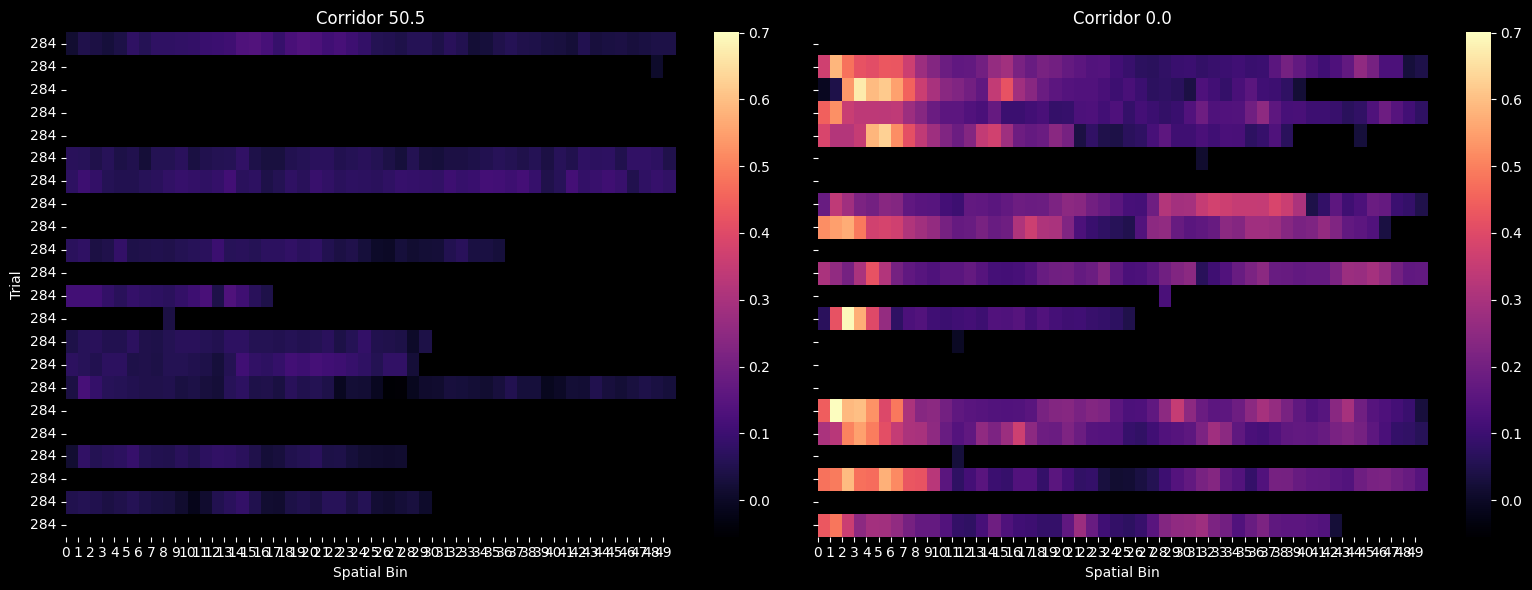

In [226]:
bh = si.add_trial_column(bh)
#trials_over_time(0, dff, bh, n_bins=30, export_figure=True) single field: # 6, 8, 18, 20, 45, 59, 81, 106, 
# 112, 210, 232, 254, 275, 278, 292, 301
# different fields in corridors: 42, 99
# different fields: 179
# fading field: 204, 211, 311, 318, 337, 346
# kinda similar fields: 285, 32016, 17, 55, 66, 74, 128, 135, 0, 2, 14, 15, 18
index = [68, 71, 74, 82, 90, 92, 103, 117, 118, 121, 183, 220, 224, 232,
       233, 236, 237, 238, 247, 264, 265, 266, 267, 268, 284]
for i in index:
    si.trials_over_time_figure(i,dff, bh, n_bins=50, cmap="magma", export_figure=False)



# small fields 71, 74, 90, 92, 118, 121, 
# large fields 236, 238, 247, 266


# 8, 15, 19, 30, 59, 60, 74, 82


In [8]:
index = [18, 20, 23, 37, 45, 47, 59, 86, 117, 118, 119, 120, 141, 144, 157,
       187, 188]

for i in index:
    print(i)
    si.average_trace_figure(i, dff, bh, n_bins=200)


#18, 20, 23, 30, 36, 37, 45, 47, 59,61, 71, 86, 141, 144, 187, 188, 212, 213 
## good: 18, 20, 71, 86, 187
# > 1 PF: 45, 47
# 7, 23, 24, 33, 36, 57, 64, 73, 95, 106
# 24: start to first arch at 0
# 33: second arch to end?


18


KeyError: 'trial'

KeyError: 'velocity'

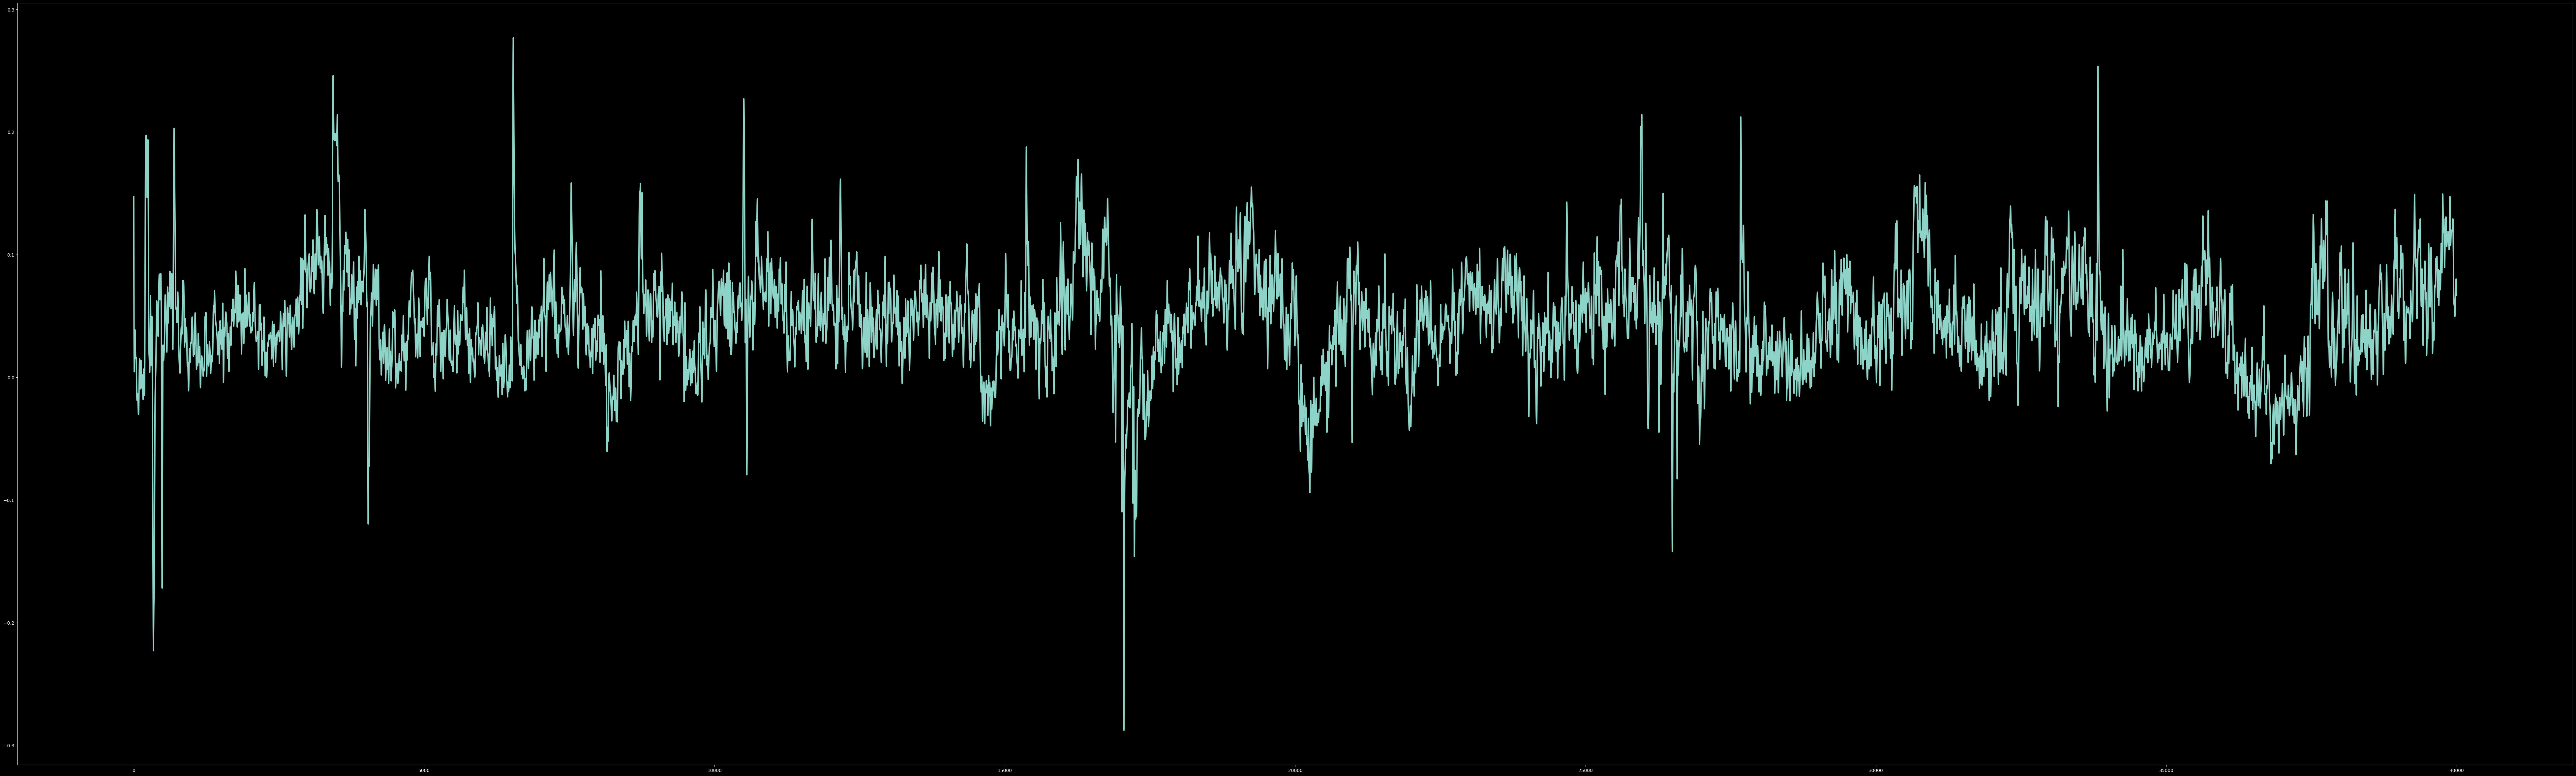

In [11]:
plt.figure(figsize=(100,30))
plt.plot(dff.iloc[:,39][0:40000], linewidth=3)
plt.plot(bh["velocity"][0:40000]*4-1, linewidth=3)
plt.plot(bh["Y"][0:40000]*0.4-2, linewidth=3)

In [228]:
bh["Y"].max()

150.323

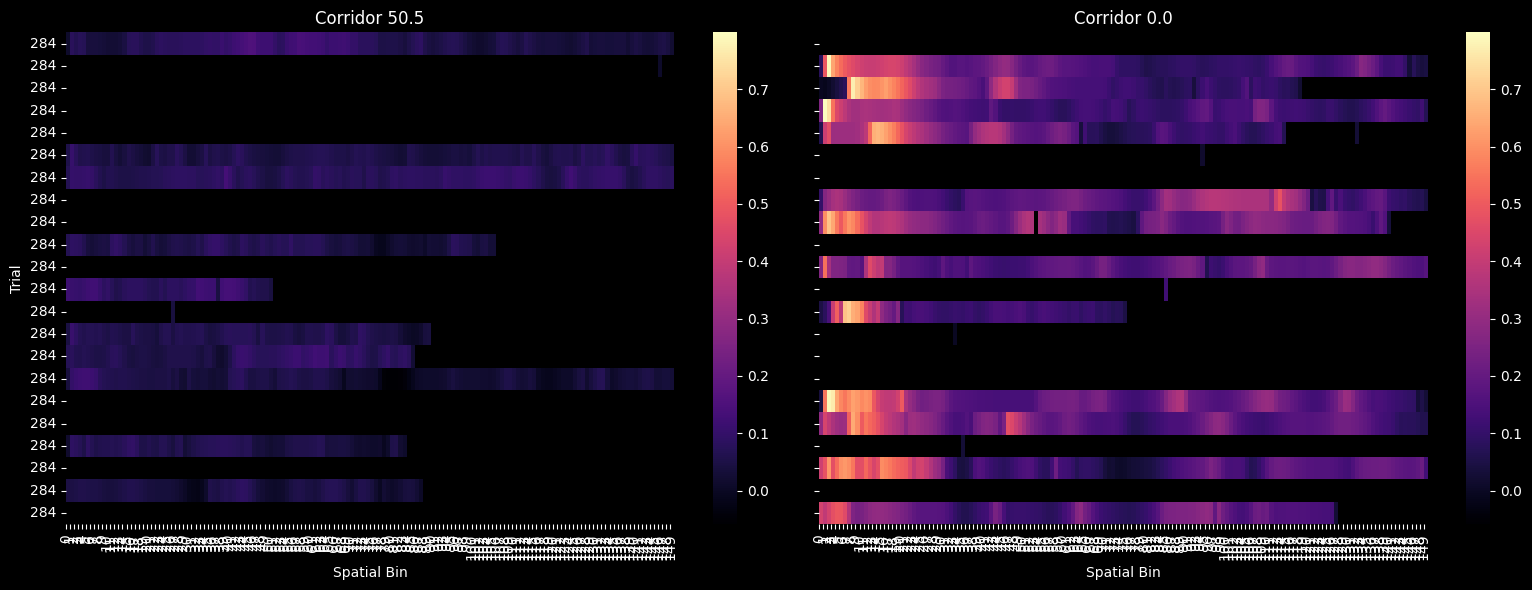

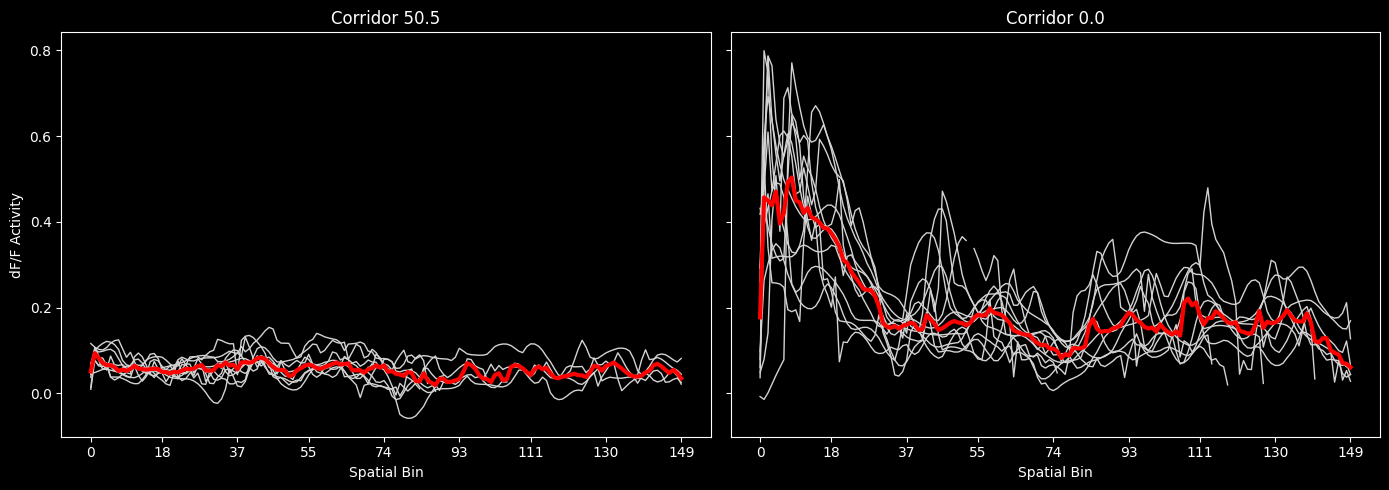

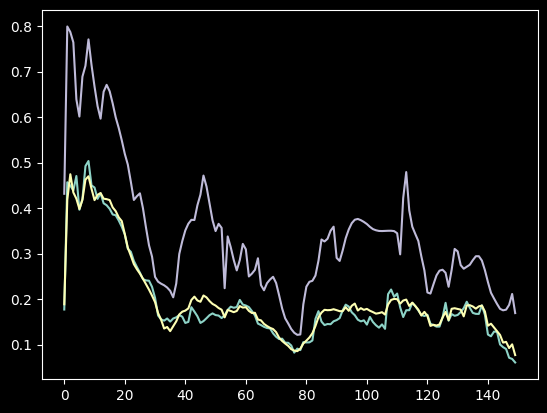

In [278]:
# 68, 71, 74, 82, 90, 92, 103, 117, 118, 121, 183, 220, 224, 232, 233, 236, 237, 238, 247, 264, 265, 266, 267, 268, 284 || 90
si.trials_over_time_figure(284,dff, bh, n_bins=150, cmap="magma", export_figure=False)
binned_activity = si.average_trace_figure(284, dff, bh, n_bins=150)

plt.plot(pd.DataFrame(binned_activity[0]).iloc[:, :].median())
plt.plot(pd.DataFrame(binned_activity[0]).iloc[:, :].mean())

plt.plot(pd.DataFrame(binned_activity[0]).iloc[:, :].max())
#plt.plot(pd.DataFrame(binned_activity[0]).iloc[0:10, :].median())

In [40]:
binned_activity[-1]

[Y_bin
 0      NaN
 1      NaN
 2      NaN
 3      NaN
 4      NaN
       ... 
 195    NaN
 196    NaN
 197    NaN
 198    NaN
 199    NaN
 Name: 106, Length: 200, dtype: object,
 Y_bin
 0      0.072969
 1      0.092952
 2      0.097113
 3      0.107903
 4       0.10487
          ...   
 195         NaN
 196         NaN
 197         NaN
 198         NaN
 199         NaN
 Name: 106, Length: 200, dtype: object,
 Y_bin
 0      NaN
 1      NaN
 2      NaN
 3      NaN
 4      NaN
       ... 
 195    NaN
 196    NaN
 197    NaN
 198    NaN
 199    NaN
 Name: 106, Length: 200, dtype: object,
 Y_bin
 0      NaN
 1      NaN
 2      NaN
 3      NaN
 4      NaN
       ... 
 195    NaN
 196    NaN
 197    NaN
 198    NaN
 199    NaN
 Name: 106, Length: 200, dtype: object,
 Y_bin
 0      NaN
 1      NaN
 2      NaN
 3      NaN
 4      NaN
       ... 
 195    NaN
 196    NaN
 197    NaN
 198    NaN
 199    NaN
 Name: 106, Length: 200, dtype: object,
 Y_bin
 0      0.035503
 1      0.030508
 2      0

In [18]:
max_value = pd.DataFrame(binned_activity[0]).mean(skipna=True).max()
thresh = max_value * 0.8

np.where(pd.DataFrame(binned_activity[0]).mean(skipna=True)>thresh)

(array([36, 37, 38, 39, 40, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 61, 62,
        63, 71, 72], dtype=int64),)

In [184]:
x_vals

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149], dtype=int64)

From the Yang et al., 2024 paper:

> `Defining place fields. The place field (PF, or firing field) of each neuron is defined as the set of spatial bins with activity above 80% of peak activity (with peak defined as the 95th percentile) of the spatial activity map. A more in-depth and systematic analysis of unimodal and multimodal PFs is described in Extended Data Fig. 1i–k, in which the activity threshold was swept from 50 to 80%. The location of the PF is represented by its COM for cells with a single PF.`

In [279]:
from scipy.optimize import curve_fit
import numpy as np

def gaussian(x, amp, mean, std, offset):
    return amp * np.exp(-((x - mean) ** 2) / (2 * std ** 2)) + offset

def fit_gaussian_and_compute_fwhm(x, y):
    # Initial guess: amp, mean, std, offset
    amp_init = np.nanmax(y) - np.nanmin(y)
    mean_init = x[np.nanargmax(y)]
    std_init = np.std(x)
    offset_init = np.nanmin(y)

    try:
        popt, _ = curve_fit(
            gaussian,
            x,
            y,
            p0=[amp_init, mean_init, std_init, offset_init],
            maxfev=10000
        )
        amp, mean, std, offset = popt

        # FWHM = 2.355 * std for a Gaussian
        fwhm = 2.355 * abs(std)

        return popt, fwhm
    except RuntimeError:
        return None, np.nan


# Fit Gaussian to mean trace
x_vals = pd.DataFrame(binned_activity[0]).mean(skipna=True).index.values
y_vals = pd.DataFrame(binned_activity[0]).mean(skipna=True).values

fit_params, fwhm = fit_gaussian_and_compute_fwhm(x_vals[0::], y_vals[0::])

if fit_params is not None:
    gauss_fit = gaussian(x_vals, *fit_params)


23.261772788898345


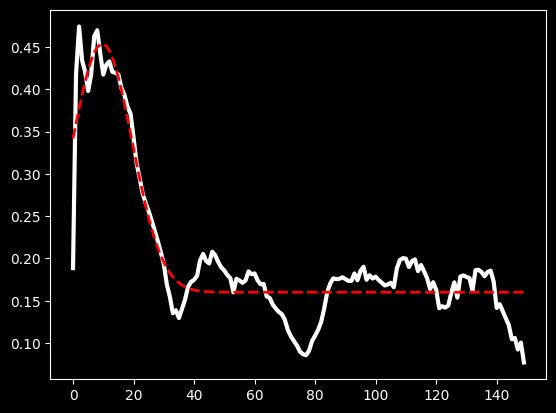

In [280]:
plt.figure()
plt.plot(x_vals, y_vals, color = 'white', linewidth=3)
plt.plot(gauss_fit, 'r--', linewidth=2)
#plt.savefig("../results/placefield_size.svg")
print(fwhm)

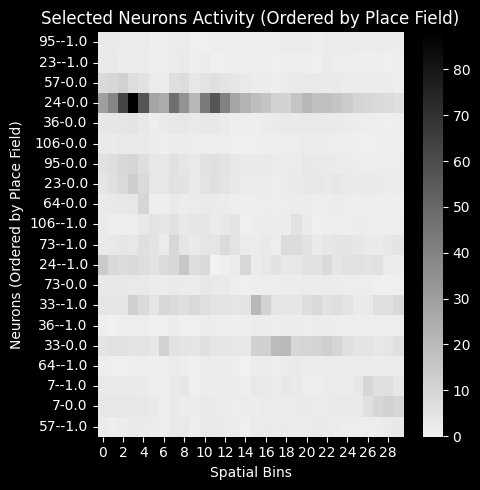

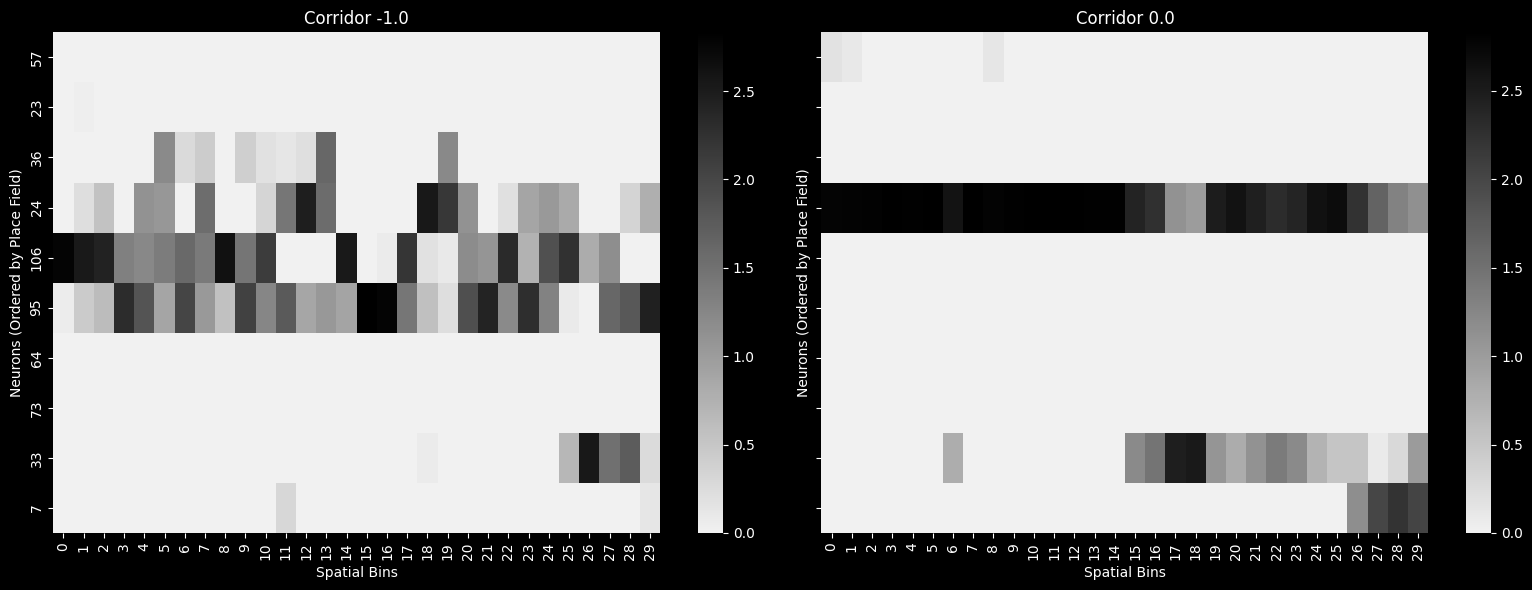

In [7]:
def plot_ordered_heatmap(avg_act_mtx, selected_neurons, cmap="magma"):
    '''
    Plots a heatmap of selected neurons, ordered by the location of their place fields.

    Parameters:
        avg_act_mtx (DataFrame): Average activity matrix (spatial bins x neurons).
        selected_neurons (list): List of neuron indices to include in the heatmap.
    '''

    # Step 1: Subset the DataFrame for selected neurons
    selected_data = avg_act_mtx[selected_neurons].T

    # Step 2: Determine the place field (peak activity) for each neuron
    place_fields = selected_data.idxmax(axis=1)

    # Step 3: Sort neurons based on the place field location
    sorted_neurons = place_fields.sort_values().index
    sorted_data = selected_data.loc[sorted_neurons]

    # Step 4: Plot the sorted heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(sorted_data, cmap=cmap, cbar=True)
    plt.title("Selected Neurons Activity (Ordered by Place Field)")
    plt.xlabel("Spatial Bins")
    plt.ylabel("Neurons (Ordered by Place Field)")
    plt.tight_layout()
    plt.show()

    
def plot_ordered_heatmaps_by_corridor(avg_act_mtx, selected_neurons, corridors=[0, 1], cmap="magma"): # FIXME
    '''
    Plots two heatmaps of selected neurons, ordered by the location of their place fields for each corridor.

    Parameters:
        avg_act_mtx (DataFrame): Average activity matrix (spatial bins x neurons), with MultiIndex (Neuron, Corridor).
        selected_neurons (list): List of neuron indices to include in the heatmap.
        corridors (list): List of corridor indices to consider (default: [0, 1]).
    '''

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    corridor_names = avg_act_mtx.T.index.get_level_values('Corridor').unique().tolist()

    for i, corridor in enumerate(corridor_names):
        # Step 1: Subset the DataFrame for the selected corridor and neurons
        corridor_data = avg_act_mtx.T.xs(corridor, level='Corridor').T[selected_neurons]

        # Step 2: Determine the place field (peak activity) for each neuron
        place_fields = corridor_data.idxmax(axis=0)

        # Step 3: Sort neurons based on the place field location
        sorted_neurons = place_fields.sort_values().index
        sorted_data = corridor_data.T.loc[sorted_neurons]
        
        # Normalize Data
        # Normalize it by row:
        df_norm_row = sorted_data.apply(lambda x: (x-x.mean())/x.std(), axis = 0)
 

        # Step 4: Plot the sorted heatmap
        sns.heatmap(df_norm_row, cmap=cmap, ax=axes[i], cbar=True, vmin=0)#, vmax=sorted_data.max().max())
        axes[i].set_title(f"Corridor {corridor}")
        axes[i].set_xlabel("Spatial Bins")
        axes[i].set_ylabel("Neurons (Ordered by Place Field)")

    plt.tight_layout()
    plt.show()
# Example usage:
# Assuming avg_act_mtx is your average activity matrix DataFrame

grey_cmap = sns.light_palette("black", as_cmap=True)
selected_neurons = pop_z_score_values.loc[pop_z_score_values>1].index  # Example neuron indices

plot_ordered_heatmap(avg_act_mtx, selected_neurons, cmap=grey_cmap)
plot_ordered_heatmaps_by_corridor(avg_act_mtx, selected_neurons, cmap=grey_cmap)

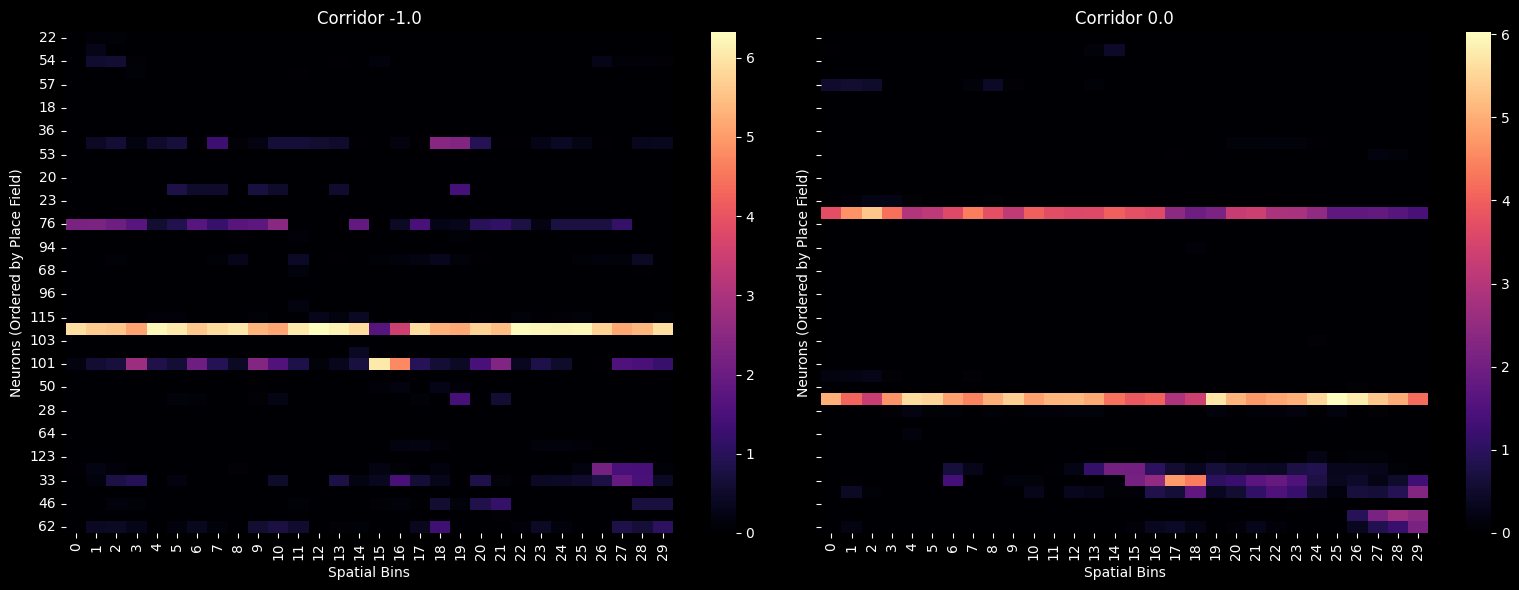

In [8]:
# Example usage:
# Assuming avg_act_mtx is your average activity matrix DataFrame
selected_neurons = pop_z_score_values.loc[pop_z_score_values>0].index  # Example neuron indices
plot_ordered_heatmaps_by_corridor(avg_act_mtx, selected_neurons)